In this project, a Convolutional Neural Network will be used to identify the dog breed in images containing a single dog. If the image of a human is supplied, the dog breed closest to the human is returned. All other images are ignored. [Here is the code](https://github.com/Pradhyo/udacity-deep-learning-nanodegree/tree/master/dog-project) for this project which was a part of [Udacity's](https://www.udacity.com/) [Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101).


## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [16]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
# change 20 to 27 to get names correctly
dog_names = [item[27:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

# print(dog_names)

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [25]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


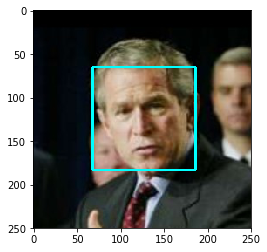

In [26]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[4])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [15]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Looking at the output below,   

- **100%** of the first 100 images in `human_files` have a detected human face
- **11%** of the first 100 images in `dog_files` have a detected human face

In [11]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Sum is the % since we're considering just 100 files of each
num_humans_in_human_files_short = sum(1 for file in human_files_short if face_detector(file))
num_humans_in_dog_files_short = sum(1 for file in dog_files_short if face_detector(file))
print(num_humans_in_human_files_short, num_humans_in_dog_files_short)


100 11


Since the face detector above is not 100% accurate, the app will accept human images only when they have a clear view of the face. Depending on the application, this might be a reasonable restriction of the app.   

However, this can be avoided by training the neural network with more auto generated images that are slightly rotated, translated etc. Providing original training images with faces that are not clearly presented should produce even better results.

In [22]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.


from os import listdir
print (listdir('haarcascades'))

import urllib
import urllib.request 
urllib.request.urlretrieve("https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml", "haarcascades/haarcascade_frontalface_alt2.xml")

print (listdir('haarcascades'))


['haarcascade_frontalface_alt.xml']
['haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt.xml']


In [12]:
def face_detector2(img_path):
    face_cascade2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade2.detectMultiScale(gray)
    return len(faces) > 0

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Sum is the % since we're considering just 100 files of each
num_humans_in_human_files_short = sum(1 for file in human_files_short if face_detector2(file))
num_humans_in_dog_files_short = sum(1 for file in dog_files_short if face_detector2(file))
print(num_humans_in_human_files_short, num_humans_in_dog_files_short)

100 20


Another OpenCV algorithm produces worse results as can be seen above - 
- **100%** of the first 100 images in `human_files` have a detected human face
- **20%** of the first 100 images in `dog_files` have a detected human face

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [22]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [20]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [18]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

Testing the performance of the `dog_detector` function below,     
- **0%** of the images in `human_files_short` have a detected dog  
- **100%** of the images in `dog_files_short` have a detected dog

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Sum is the % since we're considering just 100 files of each
num_dogs_in_human_files_short = sum([1 for file in human_files_short if dog_detector(file)])
num_dogs_in_dog_files_short = sum([1 for file in dog_files_short if dog_detector(file)])
print(num_dogs_in_human_files_short, num_dogs_in_dog_files_short)

0 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN _from scratch_ that classifies dog breeds.  

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 84.99it/s] 


### Model Architecture

 I started off with the hinted architecture with a kernel_size of (7,7) and got a validation accuracy of < 0.02 after three epochs. I then reduced the kernel_size to reduce the total parameters to prevent over-fitting and could improve the validation accuracy to > 0.02.

To try a different approach to prevent overfitting, I added two hidden dropout layers with a rate of 0.5 and went back to a kernel_size of (7,7). This still had a validation accuracy of around 0.02 after 3 epochs so I changed my kernel_size to (5,5) and reduced my dropout rate to 0.3 to reduce the number of units dropped and retain more information but decrease the number of total parameters. After five epochs, the validation accuracy was still on the rise, so I changed the number of epochs to 10 and was able to achieve a validation accuracy of ~ 0.065.

In the end, the test accuracy was **8.7%**.

This architecture works because the series of convolution layers and max pooling layers learns simple to complex patterns as the network gets deeper. The convolution layers help capture spatial information while the max pooling layers help reduce the dimensions and number of parameters to be trained. The dropout layers help with overfitting by randomly dropping some of the nodes in the network during training. The global average pooling layer reduces the dimensions drastically and converts the 3D array into a vector before the final fully connected layer is used to produce the output.


In [44]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

rows, columns, channels = 224, 224, 3
num_breeds = 133
kernel_size = (5,5)

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(filters=16, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(rows, columns, channels)))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(filters=64, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_breeds, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 32)      12832     
_________________________________________________________________
dropout_8 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
dropout_9 (Dropout)          (None, 56, 56, 64)        0         
__________

### Compile the Model

In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [49]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.6481 - acc: 0.0367 - val_loss: 4.6744 - val_acc: 0.0359
Epoch 2/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.5748 - acc: 0.0440 - val_loss: 4.6620 - val_acc: 0.0491
Epoch 3/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.5027 - acc: 0.0534 - val_loss: 4.5669 - val_acc: 0.0467
Epoch 4/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.4136 - acc: 0.0587 - val_loss: 4.5696 - val_acc: 0.0599
Epoch 5/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.3441 - acc: 0.0612 - val_loss: 4.5201 - val_acc: 0.0467
Epoch 6/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.2825 - acc: 0.0671 - val_loss: 4.5194 - val_acc: 0.0467
Epoch 7/10
6680/6680 [==============================] - 28s 4ms/step - loss: 4.2142 - acc: 0.0798 - val_loss: 4.3941 - val_acc: 0.0695
Epoch 8/

### Load the Model with the Best Validation Loss

In [50]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [51]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.7321%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [52]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [53]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [54]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [55]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 360us/step - loss: 12.5899 - acc: 0.1145 - val_loss: 11.2233 - val_acc: 0.2048
Epoch 2/20
6680/6680 [==============================] - 2s 268us/step - loss: 10.7908 - acc: 0.2602 - val_loss: 10.8764 - val_acc: 0.2455
Epoch 3/20
6680/6680 [==============================] - 2s 265us/step - loss: 10.4921 - acc: 0.3051 - val_loss: 10.6953 - val_acc: 0.2599
Epoch 4/20
6680/6680 [==============================] - 2s 257us/step - loss: 10.2833 - acc: 0.3298 - val_loss: 10.5978 - val_acc: 0.2814
Epoch 5/20
6680/6680 [==============================] - 2s 257us/step - loss: 10.1205 - acc: 0.3443 - val_loss: 10.4888 - val_acc: 0.2838
Epoch 6/20
6680/6680 [==============================] - 2s 257us/step - loss: 9.8822 - acc: 0.3590 - val_loss: 10.1382 - val_acc: 0.3006
Epoch 7/20
6680/6680 [==============================] - 2s 256us/step - loss: 9.7057 - acc: 0.3771 - val_loss: 10.1695 - val_a

### Load the Model with the Best Validation Loss

In [56]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [57]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.9522%


### Predict Dog Breed with the Model

In [85]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [6]:
import numpy as np

### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_resnet = bottleneck_features['train']
valid_resnet = bottleneck_features['valid']
test_resnet = bottleneck_features['test']

### Model Architecture

Just like the previous example, I used a pre-trained model (Resnet50) and used the last layer as the input to a Global average pooling layer to reduce the dimenstions. I then fed this to a fully connected layer with 133 nodes - one for each category - for the output. I was happy with the 81% accuracy so didn't tweak it further.

This architecture is suitable because we're taking advantage of the information/patterns learned by the layers of the pre-trained model and training it further to learn what we want.


In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### TODO: Define your architecture.
resnet_model = Sequential()
resnet_model.add(GlobalAveragePooling2D(input_shape=train_resnet.shape[1:]))
resnet_model.add(Dense(133, activation='softmax'))

resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [8]:
### TODO: Compile the model.
resnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [64]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)

resnet_model.fit(train_resnet, train_targets, 
          validation_data=(valid_resnet, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 2s 326us/step - loss: 1.6373 - acc: 0.5954 - val_loss: 0.8196 - val_acc: 0.7257
Epoch 2/10
6680/6680 [==============================] - 2s 236us/step - loss: 0.4328 - acc: 0.8647 - val_loss: 0.6994 - val_acc: 0.7904
Epoch 3/10
6680/6680 [==============================] - 2s 228us/step - loss: 0.2619 - acc: 0.9138 - val_loss: 0.7027 - val_acc: 0.7796
Epoch 4/10
6680/6680 [==============================] - 2s 230us/step - loss: 0.1716 - acc: 0.9473 - val_loss: 0.6647 - val_acc: 0.8012
Epoch 5/10
6680/6680 [==============================] - 2s 231us/step - loss: 0.1188 - acc: 0.9639 - val_loss: 0.6614 - val_acc: 0.8024
Epoch 6/10
6680/6680 [==============================] - 2s 229us/step - loss: 0.0840 - acc: 0.9749 - val_loss: 0.6734 - val_acc: 0.8144
Epoch 7/10
6680/6680 [==============================] - 2s 229us/step - loss: 0.0642 - acc: 0.9825 - val_loss: 0.7099 - val_acc: 0.8240
E

### Load the Model with the Best Validation Loss

In [9]:
### TODO: Load the model weights with the best validation loss.
resnet_model.load_weights('saved_models/weights.best.resnet.hdf5')

### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [66]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
resnet_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1))/len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [10]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def resnet_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = resnet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### Write your Algorithm

In [11]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def show_image(img_path):
    img = cv2.imread(img_path)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()    


def dog_breed_classifier(img_path):
    
    show_image(img_path)
    
    if dog_detector(img_path):
        print("This dog is likely a", resnet_predict_breed(img_path))
    elif face_detector(img_path):
        print("This human resembles a ", resnet_predict_breed(img_path))
    else:
        print("Error - this is neither a human nor a dog")
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

The output was just as I expected - no trouble identifying dogs and humans but mixing up dog breeds that are very similar. The model correctly identified distinct dog breeds like the poodle but mixed up a pug with a bulldog and a husky with an Alaskan Malamute. This is expected as those breeds are very similar to each other.

Possible improvements:

1. Deeper models - Adding one more fully connected layer before the final output layer might produce more accurate results.
2. Tweak model architecture by adding other types of layers
3. More training data - more images of dog breeds that are similar to other dog breeds could help the model learn to differentiate these breeds better. Image augmentation by adding rotations/translations to the existing training images could also help with this.

In [12]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

import os
from os import listdir

# Download some images from Google    

def create_images_dir():
    directory = 'test_images'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
create_images_dir()


import urllib
import urllib.request 

imgs_from_google_images = [
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMVFhUXFxgaGBgYFxgXGBoaFxcXFhUXGBsaHyggGBslHRoYITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0lHyUtLS0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tN//AABEIAOEA4QMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQMGAAIHAQj/xABGEAABAwIEAwUEBwQHCAMAAAABAAIRAyEEEjFBBVFhBhMicYEykaGxFBUzQsHR8FJysuEHI2JzgsLxFjRDdJKis8MkU4P/xAAZAQADAQEBAAAAAAAAAAAAAAAAAQIDBAX/xAAlEQACAgICAgEEAwAAAAAAAAAAAQIREiEDMUFRIgQTYXEyQoH/2gAMAwEAAhEDEQA/AIMJhXmoXkQA8n/ulWutQovpEuEuItz6IPBVWuc5s76Kx1eHtc0A2Oy4ORt9gmUJ/AKzzLG2HNH4PBlgAIJcFaaFJ9OQSCDohHsANlDn4ZIHguHOnvH67TsrBSqucCHCBCWNxJNpR7XNLCZMqabdghdxPw5AGzcbfq6DNEPqlzhAjQ2ViwVYOAsLblLeNXrBwAIi4C1i+0NgfEeH5WhwEg8lG2nkEiy1oYpzq4YbN2Gye1WM0i42WdyQgVnEAWWgLbhmKa5w11W9Dg7XmXNgckXh8LRp2sJVYpvY0T8QY9/2eqhw/fDwvA8xdMqdGCPHJRNEgarZcceygGo0kRMc1FTbltMjqjvpVNzo5LZ1JhNiEOHoZHhGgG0JDUOXiJmIdT+R/mmuIindvO6rVTGNdxEDX+rI9cyOlQyyYmqzMYIsgJZlJ57oipwxpJde6Cp02lhbyJUO/IG+DxrWYV8GXDNbc3sq9h8RiHuAAgT6JvhMAGtcbwTrstK9UtBLbqJvexE78IfvGZWjcIGg/NCcKxbySXi2wRWJrVHNIywOe6hteB2I+PxAzyRKrowRzeA21Vh4jhz7Lycp0m10Fg2WiDM6pXSJas84bSeZEkQmFB3du8dxzKGecpgTPNT08CXCXvlHYxp9ZU+YXiXfQWforEsQ2RYKpnqEtboU9rYgkSTBCVU61NlQ5DaUJiK7n1TlNhqul/MyG7aziZJsoCZMg2SqpjZdBmOiYGg2InUWU/bodGPqudoAp28QMZADPLdDYHA1cwE+HmmXD8EWVSWwSDM6q4xuVMKJ8FQcPbaW85stH1aRqiJIbrGih4xijmyl5zHWPw5JZTZX0psJB3j4qsVTaG9DjC1mVqxc2A1tr62Tc4um0wCCd5STBcNEEPMPPJwH4oR/CqgPtkt5nX+axnBoGXQ8SplsBwlJMXWZVdEJXhaDGmZdPQSrFwjEts3JfmYQvk9jTsLwdJzG+Fs213S7GcRa0kZXF3L8lZ2VotFuiWcQwjKhkGCtpQpaY6E+GxtTMD3JynkRIRxmZDSOiYcJohgIN15iTm09EOPxsEhZiseWkDITzVL4hjCce0tZBDY6lXo03EwYlU7iGHc3iDI1LT8FMbsGOKnFXNBBkKHB4ouE8yj8ZhCToEubRBlk5YN1CTAZDHHuQwttz9UI8iLixTXD02ihBMwhsLQnXQGyJIYtwdB+YgfFMmYZ7QS4yFM1nikbKTEukQdFDilsCo9q3vqBoaIjkl3By4C53/QVh4kwiSbKsV6Ls2u6nJk+R89zXm0IethTd1/evMG0tgv5KKtxIk5QLDVSvZTNfor+fxC8Wv1g39f6rE6FYi4fXHfkOuLwrLhcMHHYAlK+DcOnEFzhzsVYcY0aN9SumTvolHo4SxrmkGRusxoa2x02XhB8J5KUta919FCGSYLGMLCwXJPuC8bim0wS4wNz/NA4/F06XsfEqn43HmvWDHvAYJMHQkC0xt06dV3fT8PlibLPxjj1GkMzP6xx5bdSUh/2xqkwdPOI6GDbzVI4xULajgSROmXSULhsWGRIcCZAOvmt1GMdJCL7T447M8mPDIEOmd9U74T2qixuJOYch0XOcJVOUggkAxHMc2ydUZhg4cwwgG4Np3jf3qXvTKOvMYHDMwxN/RaUsE81GkOJjU9Uo7G8QL6TmOF2bnUg2nkPJN8HxMZzlPhBA+N1wT4qbS6RJbMI/K3xGSt6QkzHkoO+Y4CCp6TwN0kzRHuOa+xa3zSjF1KguARCdHExdwsk+O4r4soEgq5texWAVce/MXfBVrECoMYysTmtp+SsGIxQucqX0aLaj2umHDZZx0yb2NMTxRoguBHnKWsrZ3lzQYdp+aO4pRJbBA9FFhaeSm1wF0lZSCuGsN2OR1TwN2QuAa57wdLL2thjLvNQ7oZuzEN8lDi2EkQ7RQik7Qi3NQvOWSHXCG9AA8Wcc3iJLVXcZUv4SrBjcWS2DF1WsYfEs7tksgq4+oSJOihONIPVeuok3+C3pYObbrShbIPrD+yVin+qXLE8UKmWLuy7Euc0RsOqmxTstiTJNwpuCYtlTFOI0AgDnGpWdocaHVcrWxl35lU7saDMJRtmPpKX8Z4kynIkB3NT4DFk0iTsD8FzXj2OcXyeZ1/JbcHGpSthZPxbimYnxHz0SKhX8YIGpIvvNloBn8RNtuqGxvQx5c9l6HXQg/idGIcBvGU3HUg7IQaw57TEEWvzMShDjalTbTbfkVrSq5XeI2O2p6DmEnMdDmmMwg+EHMC8CdhcXidSiagAimXQXEScxdZhgjy5JVhsW2mCNQfu7ToY3CIoCSHu325SLe4IVMCzYDjTaILCbO1uR019Vbuz1Ed2XZszjeNIB0C50aQPKRHvA/kVdeylQMDYccx0aYyxvEC/rdRzpyi6EWTCYp7Tdpgeab4fGNPRK8VxFxbZt+ihpPMSvNpeBItH0qRlMeaHGFtMpHRxDgZk+SmrV6jrtMdOiTk7Kv2E4uiANEOSwvBAggRZRYllRwAzRHvSzDZmVSDJGxWkF5DQ6qEmZnoicA+RkKgFQRDzdaYSpEqX7Giem19Kp4SI2ChxWLqXkSSVCzFsp1CXu/RWlSHnM11thKjFlGYivUjpCQsquDnF9k4xGPcDBbMJfjWOeMwEIabRLA8dXkQ0SlTcO919Efh2OJsb8lHiHmQ3folHXQWbcMozUaCNZXlXDPa+oCNHGPwR+CxbGvYAJI1TzFND25hABTbKrRTs1Tl8SsVh+inmFiWcR4i/A4SjSxUl14MBbV6BNaSdSTfcIvB8NFSuK+XwwdfndHY7F0qrstRvdvaYZU2sefJbSRIFhKdTLUYAbyQYt11XKONyHmSdTzXesHUyjK+J581zP+kDs04vNak0uDiS4AXbYmYGotqtOB43ZJSaNeB6GPxKGNgTIm3xla1GGJBsNt17wzCGpUgtIAHityNguu29IOgzg1ItaXHR0efSFmLoj7SMxtFpBiwlH16gDg2I5dUuxNdsF0XmG9IVyVKhIEw9DO4lwA6CAB7kxxIIEDYz6bfNAYCp4b7k/wCqmNQ+GbyIPkWxPxSToBnh69+tiOV1bOAVmue0O9kG0aidPUKk4UnMzraU/wANXFM59BIM+fhKTZR1VjQOv4rWo6fZbde8LitSZUabgAHaeRR9NrmXiy8vkTjJioWCmTq2CtK73NKdvrMidCltbEsdIFynpoKB6T3OIc3QaqRmGzPzCNFOcracCJ3Q+PrtyxN410Vwi26Q+jH4UvMggEGFrxOgaQEO16pYzGumGPaRvBg+4wo8cxz3eNxBHNEuOSWxrZFh8WzvvG0u2tc66phiGOa2aQhJ+zeJp0q7y+4LYHoUXX7SOLXCm0RJ9ymSBs1weNd3kvjqvMVxOnUc5gOUDedUDw8Gu4t3Op81Hx3g4o6GZCnHZNsCwr3CpINriealrPMnLrzS6mXkiNAU9wjcxsNrolaBbI+GvcwuLhJKI750ZXOOVTYOgH5idAoauHdNwY2KjIo87xvX4rFP9EHP4r1TkAydxFlbLTa7KxuoBEnlPRK+JUHRAMgkoWlUYx3VxvZM6dancuBPJdc+0TYTwfhdbJm7zwxoT+oWjaZkguPQqOtxkZcjAQN+RW7axc0QfNQ5IEFYfA4d16wpvi4zta6/qFW+0PCGGm76DSbSeHSQIAqAz7QduCbJvRZ4ufpK2qNcHlxsOQ6IXI1JUH4OV18TUe4MqxmZLYgB07iBqguIUSbusB93lf5p12j4sHYh9UA5Hu8HhDTkENv1kFKsTjGuvB56wOWvNeg7fYAZZb9eikpsh0TaELVxEGWyQdJ8kU1hdljUm07Te59UrGFUXkETzF/JWCkzvSKQsZA/H9eSC4V2XxVemKjX0Q0k+08g21MZeaufZXs0KWaq9wc/QRJDbEOLTvYwsuTlUf2BY+D8QZRpinOmp5ppV4w0thLMJwI1BmChrYc0zBXC5OWxBtKsawJLIa3fmgWYJ7SXBtj1uiKHFCKTw1v+t0B9cP0N+XTmqi0xpkPFOJigANek2k8/NU3i3aXO4yTE2GnxUfariPe1XNMiLDbRVKoQSQZOkBenxJQiqJex/wDXbwJuCSCT0Gk84Tvg3aUhwa6XTe/i1+SpTq0CDyARGHxZjoNOZ/NaZ3piOkuo0w7vABkcLRs7e3JRNxJjI1mqS9msfmcGOFjuVY6Y7uofvclw/UQxlaKRBgKTmOJEj4KTimLljhEo2hRzGXDXZAcQpObmlsNXNY2A9mqIfVDXG2Un3Qjm1BTNTx6OI9Ev4djRLS3qNUHig81HAAy53zQ1YWXTA1aYYADJOqncA+0hBcPps7sZrEC6aUsPTayRuocVZQN9Xs/aXqlzjkViWCEVirxOi+u1gbvGisXFsE1tLNa2n4KhvblrB8aPlWN1R9VwzE5OWi3nG2hURYOnLtNU0dTIEbIOo8M9kqelVdUHhvZDiVRsyscwa0eqX8fx7qLCXauOVsX216cvMptgGSJNnKi9vcQTVyhwOUAQDeTf8lpwwUuSyZFbeSXZHAO1IBgRuRJ1/FB12wYj2tPwhHMwoBz1LnYfH0Q9EkubuDIBMmPhrJC7miQJtK9wSR+F/RNcLQLQOo9o+IEGwFjz38lqKoDw1jZAmZJmRqSAj3ESBBFxaZDTO1ttlOIWWzsjjaY8BmIAJPO8kHlN/VXLh9M+yWwPgfJcxa7uweRJudRnBDgOo36lXXgfapjWCnVnwwM0XAOhd06lZfUcLl8od+Rp0WMcQfS8LQI+SUVMQaj5INz6J5T7t7cwcCOYhA4vEUqNzuvNdgIuLuc1pyGBNwguGtcXEkmPxR2JJe6SIY4xfXSxUdCkKZsS4EXCuD1fkEcu4tWPevnWSl+I109Qrd2o4G4k1WNMH2hF2/nKp+KpRsV6SkpK0FErqgIbIkR5fHYKeOlgNdoQVIkgAR5b+qY02GwAnp8k7AsHZUDvGyJuPJdCqMD3jIB0Vc7H8PbTeMwBJEgbjzkQr9gSwVG5mbLk+okpSSKiLKnDKrfGYIGwS/j1Z1SkbRtdXDi3EWZCIVP41XD2CJ8tFztehsquAwoa4HkU5wlYOqAxYHXokz3uDxYgEwmWAwj24kCfCWz+Cr9kouWH7ouMEEFRYwnLlpi4K9wlAB10zZlGylxZQn7itzb71icd61Yp+2/YUcwzQ5wiTKOpYkmAbLXuCXGBdENwryIj4LtabCgmpw8PtmRwY6iyxEQgm4J7iAQRHJE1OG1d8zhpdZODHQXwrENvzgn/AFXLMUzvK7rjOXuO8Bo8RMn8l0p9T6Ph6r3NNm6xufCPS65xSoTUe8kyGkc5kiF1fTxq2TME4iM9gbwAIH/UT1/kvSCwMa32ToCZMAC5UzqBMZbEgztcGHT6RHmvfo4a0FxJcQRESLGIXT+TMXUgMznXn4a235IymMxncmANBESWj5SoKgh0RF/15bLajVyw4T4b6SOqkY0x7zIlpiRAn1J9Y+aIovOaG2Ba8ONzbKPAY1O6GeCXAvyEwBadYuZ5xHxWUKhg7S43GgnU+ZaPgFSAa4HidRjAWuIdlmCbwLTpY/A9NUe7tAMwL2h0DUy1zdBeLOveY96r9Gq1zXN3a0tE6xGabaoXEOIiT4SADzGXxRPUge9JqL7ViLmO0QPhNK14OcztBPh3BHuKjbjaebOC4RtAOm5IOh1HroqhTdMG9278wNuTtD6LwV3HxSZAkOsCQbOEbQk+HifgNnTTxnDPZlc5rSRqZAPrH6sucdrMDTzAU2NDRcvaLPJg2O4Hzlb0sSTBzT0P3heDI0tbzCL2AzeG4vobkRB0Ol0Q4IR6HbF/ZjssKw7xz/C18FuUkkAA6zaVbuGcCo0nlzGHexM2nqk3COIOoVBkMNzDPTnwuABnNIkai43jZXrhTqdZveMBGYw5hIzMMwWmPLXdcvPxzW70XGhHhDlrZgIvorFi8S6e9A0F4PvTFmAoB3jp38vyWrsDQLXZXFvMT+C5nAugEVczZDSZQ2IpkiMkJnRhvha6Wwhqw715a0kQLLNxCrEzA2Ycy0oujw8HEy2Y7v8AzLb6vrU3gvu2dYTzAYMmagGojrATSYgHh7QBc+KT81Le6Iw+CY17u8BE3B2S6vimtzZSSNt0U6FQXHkvUh+kv5H3FeKcWAyZgdTlWhwz42CY1QP2ivaLWCxJK6LaJsXupVGEEEH0WrsRWnUR5J0cv7J9yir4YRICd2O2VntHin/RazSGOlsAO0Jmwjdc3biYgCwFjzMax6wup9psN/8ADrECSGyLbi4K5S8Nu8yC4GLCbGCOQMW9F1cTqOiWHmoQ7M6NjEaB0T5kEKfGOaGTMy4jLyufzSynWzBjjBPiYCBBLoGQn05bzzRT2CCXmGtMHS5ifVbqVki+rUl4bDYjrI5LXC0ntgkCAZM7dIRzeJgQKQEQTzJO8nnHyWmExD3vaYbDuYkHSc3n+CTGeiJBNpAkCZkarGkQ4E+y0EETrEEG/IgXnVG8RotZlgHXK7+KZ3j8EnaQIykaGdIkHwk+alMAipVETyE6Tzgc15iHAhs2s2ZvtF7BC5nEkAXDTodpJgztZShxjLq0Rc6g3sP1umBE2roTMAHUxF4JPx96276AJt4tenOVrWYMpJmSRa+gF9d7oOq4WguHPWBblOpRdAH0q92kf2f5keaNwbxkIc4xn06fej5pAyob6jS1tvP8EVg6l73bpAkGDr6yhSAdZXOc5puLiYElsWI3991ZuxeJ7uvDz4HBrcx+B8wVVMDUs0SSf7WsHQCdYTWmyMsGJ6nfyMf6K2k40F0dlFYNjNqEFiMRSmTulVarUIDiBJaCddwCUsdXcDMeS8vVmmaLZiuMURTDC0dEsfxWmSJbEaEKvV+IE/duhncQqGwgR0VVYZot9Tj8AnLmHkswfaBxsGQPeqk3iFUcj6LWhiagJOYD0SqgyRa8ZxxxMZL+SV43HuHiAaDuCkRx7ibvE80FiMTMy+U0rDNDr64fzZ7l6qx33UrxViGaOvljSbU1KKrWj2FLmJFlFUok6rC2SzU8RH7CidxNpkFqFr4Ig2mFE6jCasVm+KxLCHN2c0j3ghcM4rLT7LgAXSNRIOUjmAAN12ymW7hcw7eUQ3FVIHhfD2x1F/iCungfaEIMFVLgQAJbe8CQdp96MFRzGtEkjpeOhjcA6pG2q5pzjS4I6GZ8k9wZBw7DGs3OpG34LpiDF9VnizM9km2YaxtG0c+iJw9xnhwygzlgSZnQRMWvyQOJqunSf3jrHxTfgtSmQZGYxaZjTSf3Z9yUhoN46x30cH2btmLRIJi94hIO8BDXgGDaAbEc7aJ3x6Po0S7K6A2TOnXckfJVgPLRAHnN1KYNBrSRLnDY3nWBv169VoWCxmDzBv59FH9LbB8MW6Rbz1UlJheQGBz3OMNZB53kj3p2BBiHxtI0uT6+SBNaJixmfwT/AOhPNV1OoXU3Ns4FrYbyv/NAcZdRpOyt8ZAvHPqVLY0gSjVnXyvNp3ReGBkwfIjWZtqgKFWbjlF9baBTNqgGRPNWmSO2tcBBAsLySZ3i2yMw2LBi0WMWIiLhwPRKcO+wmbG0EjXX4qejnLRMnXKQYid4tbZaWB2/CY2gaLCHAyxvyhCVsRTI0n0Vc7G4kPBouawuaMzIIuNxGs7+RVwoYR0SG+i8zlgoyoNifvWEwKfwQ1WkCTDFZXAz7AHVQVi0DqpUqCiuNwbjZrVFiOBVSOSeVMTlutPr+mD4oVZsLKniuA1G9fJLvq18xdXqr2hoQg29o8MCZZ8EKcvQKiqfVT+vuXqtP+1eH/8ArPuCxV92Xoei0PxzxtC0Zj3b2XtXDP5hAYiiRqQlKEUKwqpjTzQ7S6ZmQsw2E3MIljW6SkoxrbD9njH0zq6Cud/0p0v66nkI+yEc7ud6LoVajTK53/SGB30aZWNDZ6ySR8VtwR32BzuSJ/PzTssc2iwF14kNN9eUiwvolFdsbgTKf9yXUKbsv3Bq4jcx8ACuqIMUy7NqRA01+aYYekS0ubYm2XaQYmfu3vZAvbf2p3tMa9Ubg8OSWtmA6ZOsZTr1PxUyGixcK4Y2vUGHrU3OpmYcHR7OoJ6FWel2OwTf+AD++S74LOyTw8F7mw67dN/vevVWA8lk3QMQt4DSp3ZRpAdGNPzRtCgBcBoPQAH4IupSI+96KKph3keFTK/CJpld4j2SZUrPq94+HCe7EAE5YmdbwFxvFYfK8tOocQV9ACjU/aC432u4W6ji6gvBOb0IlVG/JSEuFdBLdjp5opz7QgnVLzuEa+MuYDUSrTA3w9aDc/kjhXBa0BwBaZFvSyVl2kfrkvWvuBH63CtSoVFv4Dxl9NzKgiWbwJ5EdAQSF0JnH6haHtcMh009QeoXJsFhS2DmIzCxvHkSrLwziT6ZILGvaWgkNMgEGwAMEmJ0BWfLGM1+QotGK45UdufRC5677gOITzh+Bo1Wh9KDOoJu07g9QUzo8NA3jouZqKDG+ykPw9U7H1KHdw+pHsq6Y+gxl83okNfHWgFKMr6FVFdqUyPaEJrgaFDLLigcQ0vK0dTc3RU4uSFQ47nCrEkzv/ZWKftyCi9Vq9Un2jCDfRcTLnH3p2HkNJLDrYR8+SiOOEXpmfRQn7QALmOIiSpKDqjbZJUwxwPstha08a+ZyptWBjGVtcio/b4k1wHCCGNBFpMS6emse9dKo8QfFwAuaduq04mq4mfCANOV108MUmUUfF07TImSE8q04o0gdcgt8/11SOuATrr7heD8viE94u1pLRJ8LQN7CAumICDEVCCS7S1unJPcASx7wYJeCG3iC+zQNmujmk9egJuSRInnoIRGCDnFoF4JFzbTzvAnRQxo6H2NxBYx5c7OGvg2PKGySPWys31s39lKeyga9jxaG5RodYje/vTwYVo2CwcW32NrZB9bNicp9xWjOJhxi4Hkj6bDswFTMAGrQEsX7FTBWAO0BVC/pT4I6GYgN8IGWpa4/ZJ6HRdHOPDPZbKW8Wz4uk6i5mVj9YsbXCpNlHzs9ljZTYV8eEj+fVNO0PBamHquY8aHX+aWtYIGvXz0CsRI1nK8gx+a9wwFydgTPXb4oenVym92e4jayJ7iIcDIMJ2A14NjHRBg5rHnpLbckSzFhtV0w4C1rEcy3c36JJhq4DpOlr7iDrPvTxppOa92VxDQPFqReT+9r7kmNFt4W7LUpimSAGd4LkNt4iwiNZ9FZ6XaBlVoDn926NwQOUzouW8Nxb6LS95zU2Zi14BM5hdpEaTHleVFwPij3O9qQG3H7QAuACfF81GKfZVnWq3D8982YcwQR8Fo/hbS32ZK59wDtAadRlZjj3bn5HNtYQY8JN+Wtl1fB4inUhwNiJUNYipFQxHDXifClzMI8zIMLp3dUj1K9+j02/dHwTcicTl30Q/2vcVi6dkpfsj3LFGbDEFbiiWmQJne3RaZw6Zaem1z80Jhnw8tMku0kQIFxfa1j59EVSOd0ARJMCTFhmMEpXEg2LGcr7wBIPJeCg0aDl8f5od1MGS12mubY8jET/JesxDLS+A7STFxMDzsqUkFhdMsmIH61XKO3NUOxD4EeKD6bdBv6rqFJ3N1tBaTdci7aVyMRWBgkvPl+oWvE07ArsnMABq4eVtfenPEnQ9xm/S4gJJRec7JP3m8tyE24jjAXugxc/E/ktkxsHIBLjmFote/XqjeBkMqss20zyO6WVKth4gJHIb/AIrbA0yXg+8EwSDb3pSY0dd7BV2eJnN0t0jLqBbUwri6k3MRA19yon9HGHa2jUOaXB2UCIygDSdd9dpVvpEWhwnNOonll/1XNKaTodhNfDuBlpEBDNwbyZdoiG1JmSeVxbXQqOrWqNc0GHSCelt/jKWa8CsNYxgEZYMcuWqgaZOw6oPEY9w8DhBdN55Xkc9RZDOxobBmxHr5geaWMn5HkC9p+AMxIykND4jNrAOsdYXGe0PZythHOD2EtH3otBNvXou1VcaQS6LddxtA1Q1XENqghzGuFs0iWgi4t0QsosVnz7VjLBsdVHRrObAm0zHqrx/SH2ZDHHEUmhrHklzRs46kDlvKojnwt07GFvuJFuY5c0Vw/GlpIIDmwRB3t89PckzKpzedkdSaXCW6yZEchJPuTsB1w/FObRe4kOptDmhk2a54JBI1IsQd7+iU/SQ2kQ03OxGkkHwum2g+KG7wwQDZ2vXzWlSk5uWRAIls6Ec0ANuGuBhgmHxI5H9qem+moXS+z9eoaQaHezadLbFc24U9zYc4eCbaASPavy0XTuyL6bqb5HhOl7ggC/6lZzbrQ30O6FR7fvEnotKvF3C2f0WV6TSRlflNs1rOB2EaLShh6bpc4WEgAWPLXmuapeSMmQ/XDufxXq3+iUP2/wDuCxKh79mgxlRxIqNIh05iYbE8xvuihxN9JxDA3L4vF7w2PO0JRw4uLc+Y5W3MmWxpLuVyIMIzG0Sx+YzkynMW+ICG6A7HlMKpKnRCbGo4lLmS3LLS4xBPhuCetx70G9huA7KCPCQJa2T4s24B0nqlz6zr30bbTNeL8wdF7WxT5DmvsLGdCYJLbbTGieIshpRpOcC8NgNAOUX0s4DrN1Se0XAHYhxrUCCZOdriBoIkH00VuwpqtAcDDjE7xmbud2mEJnJqEQA513ADLcXvFuVlSuL0OyjYjsbiKTmuaG1Ghzb3BOaD4QdYm/kk3FMO+nUe14cHNNxGnny2966pRqOJJc6Pa0APsjlF1HSaHNLu7PjEG5BgyCJ3/CVceaS7BSOUsaXgm7nDXlew8uUplV4c9oljS7ZpHtWuAR94GQfVXrAcCwtNpLabmh195AbsHmS6TeDzW/AuGXHNpjNoIFhbSRa/RVLlG5EnZ0GjQDXHxe0SNyRJFtY59E3pY1oLXGSRYzAB2ABj5zqkdSjFQ080ZSQCTqAdenqt35YGUkExIdAHXpPJY+d+SbZZn8XOgMCwJiw69LIqnxkHKXN1bsNZ0EdbHoAVS6pIOupEDXffyUzsU1rRck3DhbWIHzTSBNjnF8RJGYSDrIgzeR7ihO8cSHSSCBYxPrEDneJS5uJcWOJiJbawsQdL87eSiw2OLwWkGzdbRbQG3X9SmtaGn4HNbEkQTMNtc2vE+outaeLYA7wNg9Sfff8AVkvxGMBpiCLBoAP9kW3udvVK2ViHB4qZhPO+8kiPVCaegTQ249XFSjUpujxtIaDFiYgCANSuNYnAPh5iMjmtjeXXB9V1VjGve4PkOLg3NuBzidCeiBxHDg9w/q/E11i6NyTTDtJFzB25q1cRp0c2p4CoXCQfFInqBaeV4V/7A8KaKNQvBmoS0gwRlDZlp5m49IRNbhFHw0mkhrTqImztzuQpq9Fwa1rQGiBYWnn5FL7lizEHGuymW9NwDXjMAdRJ0PLw6BIqvCXin3Za81A/MBlsWkhgDT11jor8Q4gF2kEv2gWE+clBsx7WwSNzEW8rpKbQZMreF4earWU3texzXOzQIENGUAydQffJV54FSNJjmAAuN9C0DTQHYx52KTNx98+USbDQH4XMnmiWcRc3eHBoJJOk3MDSJnqrcslQOVj8YlwJLmnIIGblJ/Q9FI7GspszNcLDTWRJsAZg+qrLOPvDpzAydJdvaTflyRFfEgkOJhw9rkQD4I/FZvoVhv131d7gsWnd0uZWKK/AvkNuzv2uJ9fmFo7/AHOr+9/7QsWJy/kaeGQ4T7XE/wB27/1Lep9i7/mT/wCNYsRDyR4HmI9kf3X5IUe1U/vG/wDiavViXkZ5hvaHkfxQA+y/xMWLFnzdkoPx/wBk7/H/AAoPA/Yen4hYsQv4f6UecR+0P+L5IXiOn+P/ADOWLFoiWBP+3q/uu/hK0xH2Y8m/xBYsV/1H4Jzv5j5BecJ2/eP4rFia6Y0A8T9up+twteG7/ufmsWKSPY87M7fvVP4nKTiHtN/5c/xherFo+jQVUPa/60JxX7Rn94fwXqxYxM2b8S/4nn+ISDiGrPMLFib6QgWr9u3/APP+NNOP+yPMr1Yrj0y0CU/93H7w/wAyK4f9i/y/zr1Yh9A+xisWLExH/9k=",
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAREhIQEhEVEBUXEA8QFRUVFRUVEhUWFRUWFhgVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OFxAQGisdHx0tKy0rKystKy0rLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tNzc3LS0tLTctKysrLS0rLf/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAAAQQFAgMGBwj/xAA+EAABAwIEAwUFBQcEAwEAAAABAAIDBBEFEiExBkFREyJhcYEykaGx0QcjQlLBFGJyc7Lh8CQzNIIWovEV/8QAGQEBAAMBAQAAAAAAAAAAAAAAAAECAwQF/8QAIxEBAAICAQQDAQEBAAAAAAAAAAECAxExBBIhQSIyURNxYf/aAAwDAQACEQMRAD8A8uQhMKVggIQEDCYSCaBppJoBCFvpKSSV2VjS47+A8zyUT4GhZxsJNgCSdLBdG3htsVu2cDoDkHQ/vKwigij1ZZuW2V19SVSckJ05yPApzY5bX6nX3LOXBCNe0YBtr/ZXcuKvDSC4D2tRtYahvmdlXVFVd3I257+NlX+kmpQH4S8fiaT52+JUSelez22lvyPkQp5frdrtBe35h6EaLM4g4EF5DgRfS23LbzVouhUWQFcSYbHI3NE4Z7XMZ3N/y/RVLmkEgix213V4nYxSTQpCQhCgJCaSASTSQBWKyWJUgQhCBJpIQNMJJhAJpJoMkBCm0cTfaeL6WA6+SiZ0Q3YRhRnJLnZGCxLj8gujdXRw3ipWX71iT5bnqoUWV3dDsjWgNsTe9tyfBW2ByRWy6Czump6arnyXXrXZU/D1bUXcBmFuosNFZjgdzg0veGkbhvPzK6SjxoRx5R+bW26JMRBubrmvkdOPHP45l/BMIblJLhe+/NSYuHIWWAbb5q6E1ytuVc03n9dtaRHpQR8G07nZ8zgdb2O4Wmp4HhPsuIAJt4Dp8l1ETFIaLhWjJbXKJx13w8vxTg+dhD43Z7W2302Kq6trZSWytMU4B/DZr/XqvXpYbjZUeKYW2QWc0HoeYPW60x9TNZ8sb9LW0bq8ic0g2OixV9jmFuaXEnvN0t1A2PuVEvTpaLRuHnTWazqSSQhWQSEIUASTSKkCRTWN0CQmhAk0kIGmkmgAmEgmg2wR5iArB7SSBazbggDfTfRR6MhrS4nXVoHotlPI5jmDmQ0ja1j18VjeU6XDogGAh25JygaJUTi03ItrtyATc4FrQNNz1W6lp8xsTt8Vy5LOvFVdQVdxby5KVHIVWU0TgdNld0cd91x2dtG6lkcCrYPJCiMjap8DAeazjbWZjTdFy6qS12ixbHzRltutIhnOiLwoVXYhTSxQ6uLRVlamnIcUNs3OBe2hHUHkvPKuMNcQNRuCvTcdZeNw+ey4LGaVjQ1zb68uV+fxXf0eTddS4Ospq24VKSELvcRITSQCRTSQIpJpIBCSEAhCEDTSQEDCYSCyCCQxndzc+XS+n91KkMefKD+EFx9L+mqiOkDR8x48vgokMhc/MOeiwvyvV0dES/noCQPJXcMDQOd+qg4NS2btqrRrLb6C1yvPvO5ehSIrHlOw5rWAvkdlaNdVFrOL6OPZ2Y+G3xXHY1iD6h5jjJDBpfa9uZUOmw2H8RdJbcghrR/2K0jFXmzOctp+rsJOOYCe78VZYdxjG42Hh5Lz+bB4N2EO6hrw5w9OfopdHQtaA5jha439oEdQUvTHEeNr47ZJnzp69QYpmHopclfY+i4/hkl2l7q14iDmNOXchcsy64rCTVcUQsdlc4BbIcXim9lwXlOLYXNIbk26a2UeiwfEG6sJIHRwuuiuKtq8uW+S9LcPUcTg0PQ81wuMQDs3X9ppcBfa1+nX6rfgXEszH/s9UTr7JI5qbxQ0NY/ugnf0IVsNZpfSma3fTbhSkmUl6bzyQhCASKEkAkmsSgaEkIBCEIGEICaBhbaaB8hysY55tezWlx9wWoLpKGZ0LA1hLdATY2LievWwWWXLGONtsGCcs6hz87O9kc0tIGt9HXvbUHZYUcFpGtGtyLK8xOnbUXcT94BoeZ8CeaqsLYWStBF+aw/pFoaWwzSzuqYBjR5bqNiVYwtyBw1Gpabn3LeyS4sb7f5YKTS07X5Q4ZtbWOoHkNlx7dWt+HBVsTz3YxYczlPxW6mwRsrfvJx0tfLl969SfgUNrOYPcNFrHDVPuWDzUznmIXrgrLhKDhqjaQTKZLBwDWvzFt+bQNjdS6zDDkcM5eAB3i3K/Q6Zup8d128VFGzQNHoB9FW4vI0DUBrb62/VZ2zWt7a1w0rHiGnhmNzBd25srnHozMwC5aeo3UHCSHajUcleyM7g02Ky20iI081ruHi8kdoC7Icut35vHN+ipG8M10WS12WLiXte+7ugI2HTRet1OEU8wu9gv1Gjr9bhVzsBnjNo6mTLuGvs8ehK6aZ5iNML4K2nfmHDUL3VP3EzXCZgDmkjvXHUq44lqSA0czC+/oBdXs+CPcQ8y5nNNwbAelxqqDi+B33dg4lzHs0uT1/RaYrxa8Mc1JrSXElJZPaRoRY8x0WK9N5hJJpIBCEigCsSsisUCQhCBoQhA00kIhsibdwHUj/PiuphizSW6Nv+i5QLq8LkEjs3VjPhe64usifEw9LoLR8o/UHEIxE7MTb5qVhsYLe0I1v3T4KBxALvbfb/ADZXELrNy6ciB4LmifjEt8tdTo6WoIeb8rW8yrWlq2sN/cqQixB8Vqnns8DwCrMbVjw7unri7cqwbWC1zouIo66w1Wf/AOi6U2BIbzO1/ALPUuuvbpd4tjRtZndBNr8z5KOxkLmEOOYne5XLYzK52W1wAdLclRVHbm/ef6Fw/VXri7vbK+XtnWnpmE10bCGab6LqDWw5Ta9zZeFYfiMkTrPD3dDqSPquljxGsljd2MbxfTOQBbyupnDNZ5VjLFo3p372u/3I3bA9w7FbMKxeKcWHdcCWlvQjcLjOF6atD7TOcG9Li5W3iUmmlbUs0Bs2QD4FY9up03rMWjcvQ2w2B22XN4391eUC7mtdlPS+i2Ybi/aMHevss8RcHtI6jVTMoinyjbyriB953E72YTy1sqxW3EzbVEgH7n9IVUV7OL6R/jxOojWW3+kkgoWjIJIQgSxKyWKkNCSEDQhCgATSCYQNXmAzWBA1LTe3O3NUa2wTOY4OabEKmSnfXTTDk/neLOuZQMqBns51yQLEC1vPxUKQmOfIebeXgtsPETS3XuHmAN/FVbq3tHuk8W262Gi86MV/ccPRtmrMb3ys6o2sfFR61veYeoKdY+4Hots0eeAPGpY658lTgjUthpyGx6Xzuy/C9lm6qaG2JDVOoJA+mLhvE9kvoD3vhdcrxfhczbSx5jG4XIH4T9FOOO6dTK2SZrG4WLcSpwdTm8lubitMT7N/MgKk4VwkTauscpZcdczrL0yl4IpHdqSAbNa5vh4LS2OInSlc8cqTCqijce/E09De9ldy4nAwWaLAach8Fef+FUT44y2PI5pZci4uDv8AFT6rgykN8sbQOzvbe5HO5VZxL16mkzEzDkIMQiOzrf51WOMQCaNzDrdpseV1zP2q4KKMwOhBYXXaS02aTa9gPBSeDX1bobyCzQdC7cjmqzi7Y71v7d8zWGnhWSRhdEfwuLD6LtqcXY97jYDLc+G5+SrYcLyHOfaecx9f7JcR1XZUkvLMC1o5kkWCyj52iGkzNa7/AB5riVV2sr5PzOJHly+CjFMpL2ojURH48O1tzM/pFCEipQEIukgSSyKxKkCErpIMk0IUACaSaBhNYrJBkpFK29x+6VGCmYYy7iP3H/AKmT6ytT7QmSSXaPJScFrAHGN3svbl9VVdppZY5jvz5Lgmrvi3l0/Dc3Z1HYO9mQOj94sremb3XRHdpLdfD+y4+SoJDJWmzmlp9QusrJwezqm6NlaA7916wvV0UttVSUzWF2UFl7Xykg6G41Hip0OaVxJqZoi5oa7K6wIGgFraei2zNDzqsRRuHs6+amLzHtp2091dRhtNVBoAq3kC1iQFJqKipi75qnO0Ay2Zl91lz1FPK3S3xKsIi53tC6mbyiMePfDRWsdWPYZQHZHEt02J3U+WnADW2sN/QLdAy2q11zxbz/pCytaZ5T43qI0h4jiDY2PmdoADYeC4bijiFtUyJjQRluXE6C9rABSeNMTzWhadNyPAbLk13dL08dsWty4Op6idzWvBJFCCu5wkkhJAFCEigEkysVIEIuhA00kKEGhAQiTWSQWyKMuIaNURsgNzsBueSuOGqN8gkqGtJiZ925/LM4eyOpVDjjSGsjaCSXa23cToBZe74bwgYcGjpLWmaz9oeOsjruc30Bt6LPJO6yvSflDxiqblcfNasyl17NSDvcqACuOHZKXTybjqFf8ADNYCySmfq095v9lzDStkNQ5jw4aWUWpuE1v2y76ihuNdSFZ0cS5HC8bs7XS/NdXS1DHa5guO1JifLvx3rMLiCkB5Le6EBQ4pLc7+q3vmuN7+anXg7vIeRsNtlzfE2KtjDnHyA620srOur2xNc4kCwJXl+L4i6eQuOgGjR0C36fDN53PDm6jNFI8ItTMXuL3G5JufotRQglerEah5czsikgpIgkISQCEJXRASKEiVIEIQgyQhCATWyCme/wBlpd5DT3qZS4W4us/ujc9VGxGpaZzzZo8zyCsTkjblabnm7/OSzq5MjcrBlA9/mVz8spudVVC+4Wew4hRmTVonaddr62+Nl9JTya5gvkkzuaQ5p7wIcPAjVfSnC+Mtq6WGdpvmYA7wcNCFGhyP2icHZs1ZTNv+KSNvXm9oXlkrea+kHOINwVw/GfBLJw6emaGSm5dGNGPPUdCsr4/cOjHl9S8mjem4XWqoY5jnMcCxwNi0izh4ELASLPTaZ2lM0VnSYhI3Y3VPHL1U2FwVZ17K79LsY7ILHVShj8jrAXCpYpLmwV3hWHO9otJ5gcz4BY2isNq2tKn4ixB7iIyeQc4eJ5KkW6smL3ucebj6eC0r0cdYrWIcGS27SCkUFIq6gKxTSRBFCElIEJIQBSQUioAmsU0F9HgYHtvv4N+qlR0VOz8Bcf3isTOtDpVVCdLWAaWsPDT5KMJbgu6m3oocsl9Eq1+UBoPgoGurkGyrJgFvLSVGmaUEd69F+xrHCx0lI4ix+8YPHZwHzXnb1nQVj4JGTRmzmOBHjysfAhSPp6xKQaVX8NYuyqgimYbhzAfI8wfI3HorkION4v4XhqwS5uSS2j2jvX8eoXlmK4BPSvyys0/C8DuP8jyPgV9CzQBw2VTW0LJGmKRge06EEXuqXptpS8w8GZT35KTS0Lj712XEPBkkAMsV3xcxu9npzaoOGUh0vrzXFkmavQxRF+DwfCR7bhboOq7zguhzVDX27rAXHoqvCsMkneGMbf5NHiV6LTYWKemkaz2uyfd3MnKfgow45vbc8K58kUrNY5l80YyW/tE+XbtpbdLZyoS2Sg3J/eN/O+v6rUvTecaRQkpAVimUigSSEIBCEkAVimkVCAhJCCwdOgSqG5yxz2VRKkrDHZwbmHPqPFYGra/UahRHSlaHx/iabFBbF2ijyyAqLHUuOhH0WZUJa3LDZbXBYFSh6N9kWN5HupHnR33kfn+IfqvZI232XzBhVc+nmjnZ7THh9uuurfUXX1PgU7JoYpmatexrx5EXsgzigceS3DD77hWDVAx3GYqSMyyeTWj2nHkB9VCSdRxMGZ5AHja3r1XK4lw1A54niD8hIzsjDbeYJIt5Knl4uZVOzPZe2zczso8gLXXUYLJE6Mdk7sX66XJY487g3016rO9YtyvS1q8LrB46djckIDbAEj8XmeZ81ZOAII6gj3rzfGcSfHIZGfdyxkFzQe44O/E3wPMLsuGccjrYGzMPMsePyvboR9FeutaVtufL5vkd2dRPGRp20o12uHkfKyzmiiduy38OnwRxtH2WJVrNrVLnDycA79Vop6jMNSrbVa5cO5tdfwO6hyQPG7SFbm4TbMp2KIrFXzuzd7TR+qhy4e0+ybeanYrEFbJoXN0IWookFJCFKAUigoQKyE0IFmWMizK1yKg1pgJPbcIhkuPEaFBlZNZIKhLEBJyyWJKBBe+fYfjPbUjqcnvQvsOuR+o9AbheBELvPsdxr9mxCNjjZk4MB6Zt2E+ot6oh9GSvygnfwG58F51xdHI4yvk71mNsOTWnk3p4lehsFzmJvyCpeIMNMl9LtLCx3W3VVmVoeT4diUjGjsY8xBs7K0E78xb9V6FgdcyanLJ2lhGzi3KWk+NtOa4qXDJKTtsjmgXu4udbYX0XUcK4uTTntmPlie1xDw0uZYC9v1uohMqyrwyoqS+FlnPaCA8bOjf9CD7ypvAULqGb9mcO7IdfB42J8/0V3wMG/wCoex+eMuZ2Z5gWcS0+XRHEFMWSNnA5h2ngpT/x479slP2eLzHlJDTye8Ft/wD0XJxyL0f7fKUdrSVY/HB2ZP8AC4ub/U5eZA7FW5ZrOGs5HULKWQXte/NVrXrayQIJZk8Vm2bxVe5x6oDigs2yAix1Hio81C06sPoVobKsxKp2Is0LmmxFlqVo2qsQSMw5g66IxGkYR2keg6fRTEirKRQhWCQhCBNcsXFDSkVQOy0yDKc3I6H9FtCT23BCDNpTC0Qnkdwt4UAcsbLIhJEsCFupZnMIc02LXB7T0LTcH3hanIiOqD6x4UxQVVNFMDfMxrj4EjX43UysnDWOv+Vy8y+w/F7wupyfYkOnRr9R+q7jjCbJESNNDqqytDhMawqWqbO/MWtdeEWtq0jvZQdtNLja6vuFpMtDDSs1eI8rj+RvTxJ+vRaZXPdRANb2MeXM951e/wCl9lbcJULaendK/c989QLWDB42sP8A6oGzgihdC2RpAaHyucLAC53vcDXTr0C6WqpWyNLHDQrnMDlmz3feznEtBO2Zwvpy009F1KtCJeSfbDQ/6Ds3G74Hh7epjcbB3pYj0XikRu33he/faxgzqh0Za9zbMyOA2c0uvYrwMx5JJI/yvc33FTCJNpRnF7LEN+i9H4YhwyenhE5gMgZle1xyPuCRuCFFp0tWvdOnngcsw5X3HWFQU04bT+w6JrwA7Prex1v5LnWHdIncbRavbOmd1mCsEAqVWeZZU1WSwtPIkei1XUWB5zuHipG2QarFZvF9VrVg0JIUjT0WZQhUDan9ChCJaW+3/wBVvSQoQHbICEIlrdunHuE0KR6X9i3/ACp/5cPzevV+Of8AYP8AAfkUIVJWhXY//wAODypv6grLFf8Ais/mx/1FCFCJbne3D/Mpv6XroQhCmCXNcZ+yP4f1XzNiH/KqP5z/AJoQrQieGh3P0UWr393yQhRLTHykRbN/zms4k0K0fWFL/aW0c1ghChUyoTf9x3mhCkSjstaEK0AQhCkf/9k=",
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEBUSEBISFRUQFxIWFRYVDhUaFhYVFRUXFhcYGBUbHSkgGBolHRcVITEhJiktLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGy8iHiUyLS0vNTctLS0tLTAtLS0uLS4vLS0tLS0wLS0tLS0tLS0tLS0tLSstLS0tLS0tLS0tLf/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAAAQMEBQYHAgj/xAA8EAABAwIEAwUFBgUEAwAAAAABAAIDBBEFEiExBkFREyJhcYEHMkKRoTNScpKxwRQjgrLwFWLR4SRT8f/EABoBAQACAwEAAAAAAAAAAAAAAAACAwEEBQb/xAAtEQACAgEEAQMDAwQDAAAAAAAAAQIDEQQSITFRBRNBFCKhYXHwI4HR8TJCQ//aAAwDAQACEQMRAD8A7iiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAihEBKKEQEooRASihEBKKEQEooRASihEBKKEQEooRASihEBKKEQEooRASihEBKKEQEooRASihEBKKEQEooRASihEBKKEQEooRASihEBKKEQEovKhAe0Xi6tq+ujhaXTSMjaPie4AfVBhl4ioU1Sx7A9jmua4XDmm4I63VZASihEBKKEQEooRASihEBKIiAIiIAl0Xk7oD1dF4uvQKAlEUEoCVF1TklABc42DbkkmwAG5JOw8ViKjiemaO5I2T8DwR+YLDaRKMJTeIozd0utOquMx8OUfUqxfxU92xPzso+5E2o6G19rBvj5WjdwHmQFhsS4qpYfelYbdHD9VrrcbcTq8D53/UKqzHOWdj/AhpPp1Wd2ejH00oP7lkscS9qETfsgD47rXKv2qTfAt3Y6hn+2paYn/fSsv63apl4Nwt/vUUIv8AczN/tICrlXY/k2a9TpYcSref3Oay+1WqGx+birGu49qqpobLT0ko2b21N2lifukuABXSZvZXhsmsbZI/KUkfIqpS8Atp3B9N/C5m7OkgJeD4HMbeYso+3Z5LvqtH3sw/58mmYDgNZ2kU7w6MwkOijjc8NZY3tZzu6w65mt3DnDmuhwcQzssJY4yPWM+Fg67T+ZUZ6Wua0ufHE8DcRyHNbwa4WJ9VimY0x1xexaSHNcLFpAuQ5v8Al/FWxio/JRNq/nCf7G5UuOQucGuJjcTYNlGUk9ATo4+AN1lrrmL8QjALQWhpFi2wMZHQs2A8rL1ScQGE/wAt9m/dc8vit0a496M+F7dAs7iiWkl3E6ZdLrXsD4qgqHCPMGS/cLgb/gcN/Lfw0WfDwspp9GrKLi8SR7RQ0qVkiEREARQiAlQURALrzzUPeBusLW8VUsRs6VpI5N128eSw5Jdk4VznxFZMR7S8eqKKBk8GQRh9pXObe17ZQB0J0Wz4TWdrBFKW5e1Yx+U8szQbfVc8414xgqKZ0MeQuLmEB4cR3XA6gNOuh6qnH7V2ANaKdxIAFm232sBf5KlWwz2b30N8qklDnk6mXLH4rigiaQBmfYENzWAHJz3fC3015XWpR+0RkoBETmBuspcQcv3bW0N+Wt/DmtG4i47fI8iJotckAi4J6kH3j5rZjHJz2sPDM/xbRmpj7StmJY4kQxXyQ31s4M2IboczrnpZcvxpgo5rUtT2jbAmwt3uYDdiPHRUMRxupqZO++R7nGwFyT5BvIeAss9gPs7mms+od2TTrlb75Hj08lN1rHJmM3F5iyzwziQSWa45Xny18jdZQ1zh19L/AKhbhDwJSMYAyIZrWzP7xd53Wv4jhzaSRvaMzxFzWlrr3jLrlrg7m02t5laN2lzzA7Wi9VxiFyz+pYDFHDx9b/RVBxBI3YlY3ifHIg/saZjbNNrgbu/F0Wp1VXKSQ5xFjazfluqI6e5/ODo2+oaaK5WX4X+TepuKjs7L4HNYg+arUHHtVGcha1zCLteZLNtYkX6dPVc4paXtJGg3Nydz0BP7LKTG1h0bGPVrGg/UFbGZ0pZlk56hTrZOLjtxzwzolN7TZhvCzflOVt1BxRiL2hzMNe5rhcETCxHhchcHZOWkFu42uAfod1EdTI03Y97fwPLf0Uo6nyiFvpcP/Nn0O/iTEGtLn4XKABraVrz6NYXE+QC53xDxDHUSdo1jopGdx7T7xLXXGbQEFpva+o2WGwCrxAfzDWTxR2IzSVDyLHQ5Y3E3PiB6q7ZiNLB9nGZn7l8utzzJHMk663ULb1JYXBbpPTp1T3Pn+fJTpoamf7GKR/iBZo8C9xDR6lZug4MqHG9TURwj7rXOe49QSLAfVa/X8Y1DtM+UbAN0sOmnLwWFnxyU/G4/1FURcV5Z0LK7fKj+TqtPwTShtmzOcRqBdrADy93Ua2N91jcU4prqCpiMtRLLE2wfEKTK29vcNS4m77EOvfax2IXN2Y3UD3ZXt/C4g/MaqnLicztXSyuPV0zyfqfF35irvcSXCNB6Rzl90so+nuFsZZW0kdTGHNbNmOVw1aWuLHNPWzmkX52ussud+xPFXTYe6N5JNNK5gJJJLXgSC583OHoF0NbMXlZOHbX7c3ElFCLJWSoRHIAsXj2Ow0kfaTOtya34nu6NHMq34n4jiooTJIdfhbfUn9h4+gBJAXKpZJK0vqq55bCQezboCdQQ4Dk23+HdRk3htGxp6lOaUuivi3ElZiTyyEFkY+EGzQOr3fF5Ba/iNRT03duaiXnd1omem7l5xjia4/h6RuVl7d3d3l4qxp8Kazv1JudxGD/eeXkuZLzLlnrKaoxW2Cwv52RTQz1ZvoyMaF1ssY8AB7x3019N1WmZBTzsF3Ftu7mA/mSAm93e7lb3Rlt4+dSorydBYNGgaBYAeA5KyqQ2Rpa8XB+Y8QeSxXdFSWVwT1Oltsqag8MsxWvdfVzsznOdmcSczjqT42sLq+wfA5qp+VjbAe847N8up8lU4dwxhl/nSgs0s0DK82ABN9jt6rruFxQhgbFYAbDYrtwui4/aeLvosqk1NYZisB4VhptQ0OkNrvcO8f8AhbGIx0XrJZUZZbak6eai+StPBW0AXMPaPiwdKIgfdtm/C0b/AJ3s+vRbZj/FkMETjmbcDa979B81xaaudPIXutmmcTqQLAXAH9x/KkVjsy25Pgt6q5cTa2l7eK8T2LietiPUK5ipnHV+2ul9deX+FVIKSwFxcgAabaaKFl0I/J0NPo7bGtseChhsHeLibZR+ul/8/wClUqH5jfrf6kn91eCnJHQdEIa1c6zUb3wei0ugdUeX2WUVK5xGh1NgOpOwV2JYoD32kuGnvNuDzu0qjLWkG7dLbHmsVPd9xqS7bzJSEd3ZHU2qmL2cs2GeuD2h4eXchcWKsZJydlGTKxrB8A18SdSvNlHbFPg2YWWSgt3DKdlagvleI4GOe48mtJJ8gOSupo3OIYwXdIQ0Ac76W+ei23AaOK1RRQEB8fZtqZgbOfnEkcgY7k1kjobD/Y6+5W1RDKyzhepaqUH7cDUqvhGujYZHwPsNSQ9jsvm1riW+qs6GUkEO1Ldj4LoOA4X/AKd2bHuvLUXN/hNm5sjG8426532Fy5rQOa1biChEdfPHE02c4ZGNFz37ODR1OqusitpztJbJW9nYvYJARQzv+/UFo8ckbNfm4/JdPAWuez3BTR4dBA62cNLpNRpJIS9wvztfL5NC2RZisLBTdPfY5EWRSikVHkrGY5jEdLCZJNeTW31e47NH+aLJrj3tflk/io2knswy7RyzX1J9FXbPZHJtaLT/AFFyrbwWFY99VL/F1uVsbTeNjzZumxI5i3L9ytX4qxGaaRrYiXtdoLMsL9AOTfErzLUPlcMzi48rnby6D/NVUfPkGVm5953XwHQLQnqnL4PU1elxrjhPnyUsPpW04uSHSnd3JngOp8VEkpJuf1XulpJZTaNjneQ09Sthw7gxzrGd9hvlZv6uOn0Ko2ysZvKVVEcNmr5uiyVNgFS8AiM67ZiG/qt8osGghF2saLfFufzG6oYhxJSw6OkBd91ved8grY0eWakvUHJ/04mBpODHnWWVrfBjbn8x0+iz9FhPYi3byu6ZnMNvI5brX6rjWR5y08G+xe4/2t/cq3YKuo96SR979yBoa0dQZLWHoHKyLjD/AI9mvbCy5f1cYNrrsVEY79VlHQn/ALWv1lc+S/ZmokHw5YbE+Jc85bei8MwGoYMzWQRdXOeHv9Xu/a3ksLW4i8Ejts9vuuOVSlqbPgqr9M0754LXFcPNwZ432J0zSgm/4WZRbzCu6XDqNzT/AOUKd1gbOprNPXUEXPk5YuomMjg7QuHPNc7Kamnc2Nji4ESXsOQFmn53J/KoO2X/AGLfp6oJbEv7cmfrMKpIW3dK6R7hdtiLH05LBSVAGwVu56oSOVMluZuVy2LjlnuapJVm5yl7lSuTsFZGKRCy1s8SOVajht3nb8vDxUxxAanU/RU569jdzc9ArVl8I1Xsg99rLghew1Y1mKtJ90+hushA97/so3u9LD57KLpn4Jx9Q0zTe4y/CUQdXwkn7Ptnjb3oqeWRp103t8lsHCTKVrJI6Ls3zNyumc+dxDhcsYS9rAwOzPBs17hruSNNRw6rkpqlkuVpfE5sjRe7XDKWvYT4tJC2XD34XC2aSmqexM5jJjlJzRZM7g0MDbus8sOhsQ2266FSxFI8vrLFZdKa6Zf/AMbFW1IqLRHsGlmbK9kjQ2/am5/lvYNSCNQXDqVlOD6GMvdiEsYMtS98kROYmOEnLGADoDZpdfezwDssRgeFOqmCGCN8dI23aPczK+ptq1jW7shBBPU5teS6LS4UdLgC2gA5AbC3IK5Jds1cmWoa07hZ+J9wD1WFocPI0WbY2wt0UJGUekRFEyeSuC+06tlOJPbLfIyzIwBs0gG/5v3Xelzv2n8NdrlqmNJdECHhrXOcR8BygEnU29VTfFyhwdD0y2Nd6cv9HK2RGwDb3ebaNJJ62tyWx4LwzE8Z5H5xtlGgv0PO/gqP+qRU8Ydke5zRkFm6acs217789tFb08ktaS4zsgvpkZfM4dHO5j/nZc+Nai+T1Vl85x+zrybRU4vSUrcrntbbZrRc9PdCxjuJamfSipjb/wBkmg33ttvdesOwemh1ki7335O+3zuDlb8gsjjNcYYgYm5nP0YA24vb3tBqB4aaK/LSNDbHdhLL/U5xj2KVRe5lS+S4+H3W+gG4XjB8IknI3a09G94+QW44Fwu6o/nTnuk3u7d1ubQdh47LK4pjtJRDJCBJKPhadB+JyzCKxmfRG26W/wBulZf4RRoeGIqeMPnGh1yl+o5d5o94897BecW4whhGSmaJHDTTRgt1Ol/RapimLz1Ls0zzb7rdAB08f08ArF2VrSTpYX0A5dVTO1dQRtVaaWN10sv8FPiLiKZ/2ry4nZgFmD+kcvNYiiwGvrO9DDNINrtYcnlm0bfwus5w1hsLy6srrdk2SONrXAlrpnkZWvAP2TRZz7akaDc32ybAq2WpE00hZBE1sjacVHZ5C0kCAtYRG2Np3kA9wX1JW/VWornlnnNbrZWycVxFdHJ6zDqilflka6Nw5OaWnw33HisxBUmWIOO40IvpfqFuuK10eJYVUy+8aMvMUjhqWxujElgdQwsmaQ07Frei0HB2ERG/W/0UNTFbcl3pVj93bnjBdOlFt1Rc4nZeHvY3U2urd9aT7rfU7LWjW30de3UV1r75Fzl66qnJVNbz9ArU53bu9ArqhwqSQ2jjcf6f3V8aPJzbfVMcVotJZJH+6LBVKbCb6vPyW64RwDUSWL+4PLVbvg/s0jFi8OefE6LZjBRRyrb52vMmcvw7C2XGSIuPUi//AMW2UHDVVKBZuUeOn6LrOHcKRxjRrW+Q1WZhw5jeV1LgpOX0ns0jeP5peSd8pI+Sz+F+zajiOYQBx6yPe76E2W9sYBsAF6WAWFNhbWi2lhyAtZXbIGjYBVVCzlgKVClYAREQEKnMwFpB56KpZCEHJxrj7gnNKaim7khPfbsyXzaNA7x8FzOvp5YyTZ7S0kX1Go8ea+o8SoRI3bX9VzzibhZsoNxt8vkqba93KOlotYqk4TzhnKMI40nhOWQ5h4raKTiOJ7czO0jJ1PZ2sfNh0PPlzWFxXhIg6adLgn6jX6LE02HSwSAhpLdiAbi3oteceOsM6lM3J5i1Nfk2fEuIZnjs2FsYF7kZgXX6MJIZ6ellgmQC/Mnnqqz3964a7nu2y8GbW2nz1+QWvLfI6MZQr64RUDVSrmdwj72UfNwCGY+PysPmVb1UjiNgNjc67G/kkKZbkynUa6hVyipc4NnODQS0NC6eXLTtM75AHgB0jpgCC891oDBru617BbRU8VshgNRS2lZIWQ08bbiR+Z7ogLm4uLaaa2F1oWGcQRshkpqyEzU0hzgCxfDJpfKHHVvgCCNbbrLU/FFI1rafDqWed7b9mwRFjBcuN3tu51u+6/I89F10zxzRPEsv8Nh7otBPiDmNsGxg5WPEkzyY2t7S7msYXEXdlJuba6G6ncG2DiB52XRsN4JramY1WIOAe8CzRbutHutYBo1oGgt9VuVHwbACLxgnxF1GSyy2uzZ0cMosGlkNo43OJ52/dbVhPs4qJLGTuD6rt1BgDWiwY1o8gsvBh7G8rrOEQcmzmWCezOBti5peepW7YfwvFGAA1oA6BbE1oGylZIltBQsbs0K4AUosAKFKICEUogIRSiAhFKICFKIgCIiAK2qqRrxqPVXKIDTca4YzA2F/ED9VouK8NytJLb/JdsVvPSMf7zQU7MptdM+ca3C5QdQfyq0Zh0p0DHn+kr6Lk4fhPw/Reo8BhHJY2ol7kvJwei4VqZNoyPErZ8M9nrnfbW9Autx0EbdmhXDWgbABYUUZdssYyaDQezmlBBdAHEffJ/S62ihwNkTcrGsY0cmNDR9FmEUistGUDByVwyMDYAL2iAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgP/9k=",
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUTEhIWFRUXFRcVFRUVFxUVFxUYFhUWFxgVFhUYHSggGB0lGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGCseHR0tLS0tLSstLSstLS0rLS0tLS0rLS0tKy0tLS0tLS0rLS0rKy0tLS03LS0tLTctLSstK//AABEIAOEA4QMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAADAAIEBQYBB//EAD8QAAEDAgMFBgUBBgYCAwEAAAEAAhEDIQQxQQUSUWFxBoGRobHwEyIywdHhIzNCUnLxBxQVYoKyc8JjkqI0/8QAGgEAAgMBAQAAAAAAAAAAAAAAAQIAAwQFBv/EACkRAAICAQQBAwQCAwAAAAAAAAABAhEDBBIhMQUiQVETFEJhMoEVIzP/2gAMAwEAAhEDEQA/AKFyYU8phXpjyzOJJFcUEY9qKgtRVBkdKa5dJXCoQGUWmhkIjEQBVxdTUoRxQCjlAKKIzqSQC6WlEAwppKeQmlhOiZUI7GhOTYT1GRDSnsTSnsQGHJAJy5ChBwCRXUxxQCCqIQRHIYRQrHJLiSIAqYU8obkhY2IpQmp0qEXJ1qKEIJ4UIOhcK6uFQg1PYmBGpUyVG0lyRJt8D4XWUnEwBKtsF2cr1LhhA4u+Uea2fZ/smxgD6t3aDIfqsOfX48S4ds3YNBPK+VSMbs7s7WrGzSBxIIEeC0uF/wAP2bwNSoSIMhtjNovwiVtg1oEBR8ViQ0WXGzeSyy6dHZxePxRXVlVS7LYUM3Ny2pOZT6XZzCNECiDzOalsrAao7KoWP7rI/wAma/tsa/FFZT7M4SZ+C2ed0HaPZZjwdz5baWHkrg1envvQ6ldFavIudzA9Njf4owG1Ow1cXp/tOQcAf/0VQ4zYeIpfvKLgOMSPJeqOxZBg/om1cYDZ2R75HRbMXmskeJK0Ysvh8cnceGeNuC6wrZbf7N77t+i1pB4GFQVez9dubD6ruYddhnG9yRxc2gzY5VTZBC6ER2Fe3NpCYAtKlGXTszShKPaoSG5EKG5MhQL0wIj0MIinUl1JQgRDcERMckLBiS6U0o9g6HBFahBFaoAemwkF2B0UGDYbDlxsO8rbbAwG780NiNAZ8SqDYYpAiWFx5mFq3YkvhjRuiLxoOC4nktVKK2o7njtLGXqZY4HGNJBJtvQ0dMyretjABndYHHY0trMptiNIMxGivcM4ucL9V55zdnd2fsunVvlUdo33QdLpO/Crv84WbxtmRqlYUSdo4vc+kWH4UfB7QFQfJZw0JNuaze1duG7PTWcvOybsTZry8vNQA2O60yR1KXa+0Oqrk1I2i9p3XCec/oijGh2YIT6dFrxf6uPFQsRht3O/AjPvR5BSG4moQZF9eIK5UxLS2f1jrFx1TZtB7j+VDxLiBwIyP4OqUdImUcYAeov+Rx9VYUiOnUZflZykG1GQ4XFwbjLUcFb7OYN2zi4dZI/KkQTQfH4am4XA8Fj9rbLMktbbqPQLaupA5EKHi8I6PlIHVsrqaLVzxzRzdXpYZI9Hm9RpGaE4K62xgw0k5nWGx91TOXq8U1NWjyuWH05UwL0NEchlWFJ2VxJJQlhgmOT0xyQsGppTiFxMhWdBRAhpwQIggSK4Cu9UHwMuS62DSkzFhrp5qv7a7fqUKbxTMEkNkacVb7GJInJoyA9VUYvYBxtZ9G9jNtJkd3VeZ1892ZX0eo0ENuG0Vf8AhwypWeXF5cQIiI3TN762XtGBwm41QuyHZSngqYaGidbyZPE6laH4Ylc6auTZui6jRF+FZZnbzvhkkERF50PFat9OJWd7S4EPpmxPIW5x018VU0WRZ432q2y4OdumL5ceEeZ71SbP2rUp/tDXPxJ+g71wLzvadMlpdp7DNSvYE2kciDohM7C1Hn75HPPzW7HKCiZskJ7uDSdmP8Q/iFjalni28f4+RHHLjqvQquL3oINnAER75Lyyh/h8xjSXF28IMsmbe+SvWbQdTpBgJcG5E/VbismXZfpNGPdXJqKmKgi4g59eI5Hgg13hzSI6LON2wHtk9/5UintCMzp798lS0XIl7MfZwdle/D9FZYUNDpYbatNnM4n/AHDpCrsKyzo+qd5vA5mOhuO9EawNLXMJgiQOH+3nBiORQD2aBld2UjlPLipFHEhx+ZvXiO7gqx9cbocLRmFGZj5d8pEa2nI594v3I7hdllltPZlIiRaekHxWB21hG0yN0m+hiy9EoVviNILQf5mm4cOIGqzPabYTQBUptMciSByg5Lu+M1a3bZM4nktK3G0jGOQiiuzQ3L0p5hqjiS5CSgAwXCuhKEhYNTU8psIoBwJ4TYXUSDgiMbrohNUTaO1f8uWG28TaYIAbF4OaqyzUINsuw43Oaijf7B2c5wDqn7NhEguMFw4tGZ65K0xG12Ydu7habRMkm0knUleVjtS4uvUJJuS4zJOpnNWWF7X097dJaTy0XmssPqy3HpcT+nFR+De7K2rWqOEyVrcJUsN6CV5TS206k9rmu+UkB7okNDjAnhcrWYPGRUIDjx+q3Hw9yseWDgzVjkpmvqVhGSqMZVBsOneifGkSbGNMlX4h020OU31VMnZbFUyjxeBG+Xbufsg8v0Qa2L3M8u7nn0+6uqLwZa/iQf0UfG7I3hIvzA0580qdFj5KLEVy4ANNv9oi3PkpWE2ZvAE/ifJOGD3Tr4m3gp2BI4ieU7x6aodkKnaPZwAGpSy/ibPis7inlkDi4AdHGF6LSrZ/NIM53H91jdtUGnE0hoazCeUODj5AohizQinus3Rm6k9oOocKYc0jvChukMYeBcCOTg63iB4qS+vvPaf5WmfT0t3oVUiGjj9j/dVWOgLqzoMHS/MaJmDbNgcsj3a9xKE75XQTAJLZ5mw87d4XMHXueOfXKfTzRoZMucLtAtaQ4/M0wfypeF2nvS0348/9wWadiZcWnVs9Wyb9ZhTqY3QDN4Pknx3vSK8kVtbKHbu58Q7o1VSVLx75eeSiFe6wqoI8JqHeRsUpJJK4oCBdXAlKQcUJELoXVA0c3U0hHQnBQjQ0LM9tcOR8N+YcHMA1BYQSe8PHgtMonaLZpfhhVaYdTc6Bx3gJEdyx651i/s2+P/6/0ef73pC5TO6b5j1THfdS8PjDZsNJkfM4TrkuMdwuNnY99QBjp3SRxEweOZ6L0zYDS0gAk2vfvuJt3rzbYdOTvO+c2aAMuPCJXo+yg0BtrhtoB7oMfNms2dWi7E6ZpsPi3QRmIvPFR3Y2Zblw996WGqh27a+UyCm7RwkAPGX3+yws2ROB5cfqvwzmNDzVjhKrhGfeJGSz7sVJE58enFSMJtltMw458YMZ5nvQqwsvnYVtS5sQoVbClh0jjEeeXeVM2dtKlUsHC4n3oeqmV6bYN7Hhn4I0K2U2INryHcxE8uqx4fvYunJszfc7oGO/IV9tjGGiTOlj05N/CxX+rhuLDjkd5oPUZ+WXNMokTo19Bwi9579L936o1KrJHgZ5gi3eoVIxM9+nd7/lKJhacmTpM8hEx4eizM10SsRh5bbP8e57gql0tO91P3jzWjY2G8b2VBjTLiBxy99fLkrEVe5Gp1N54PDLob++qtcXiNxm8dTCrKdEsG87uUbHY3fAboDI8Ml1fH6CeSam16Tl+R18MeNwi/UQqjpMoTiiFDcvV1R5J9iSXEkQBQkUkilGFKe1MT2qEQ5NKclCiCwRCm4eH0alM8N4dQorgn4WoWuBHRUarHvxtF+lnsyJnne16EONo46T0CiNbuQT7i9vDzWh7X092o4gTJnoJmB0yWcbW0dccOvBcBdHoTV9n5i9vmgagkQI6zZbjAPdkQRkSAREcfP06jAbFxEQQ4WIPADQtdNpyMidc1q6eLgfUJBvAmd4xaO/utEmDVkVjxdGooPgj5o4h2RPEFWtHFtI3Sc7ETP/ACCyjCLGZi/yzkeIU/BVZIAEQczrOlljnFmmMh20MB9W6QTxyPeFmdp4J0GStfi8QAbA5ZiPQ3WG7WdpGU5ZThztb5dwySwg26Q8ppK2UtLblbCvIk7s3E+YHFbTZHbMVALzb2CF5NicQahLjnOkqd2d3t8xlqtU8K237meOV2endo9pNrU9d4CxXnOIqHzhaCrVkQeCpsfTsfeSqgWydmx7MbU/zDd2f2guQdRNitGx8PBGevgB4QfVeN4avUpPa9hIItI9FodldrK1Mhj/AJwMicwDaDx5KvJp75iXY9RxUj1A1YaToVW0G71QE+/cIOydoHEZiBw4q4bg9wgjI3/RJCDXYZzvoh9qmQxrhxg9NPRZaVqO0VX5AOI8wVlyvW+Nf+k8l5NL6w0rhTimroM5yFCSUpJRqCLhTkwoEEE4JqcCiEcnBNTmoBOOC7Q+oWnknkKXs+iCZJgLPqcihjdmjTYnPIkik23sM17fTra8dVn39kyNSfJerUsG2JAmc75R/ZRKuEbnwXnIyfZ66GCLXJ5lhey7ybSIsrnB9mMWL03AgaEZ9632C2e0fLNyLfqplTbuDw4LH12bzWy4D+HWfJG7I8UEjzdu1K+HO7XZEZkjSbGev45qTT7Sh5G4SSbxa45jl9+9A7W7epYuoNym80wLk/LvHrygZ8VQtrNYAaUsEmflk628YU2WZm9vRbbR7T1XzTZYxZxOQ+8+ULH0sJVrVC0fO65JJ4XJkqWynvX3myBDZ465apDEPpsexhtUgPdEF3IXtnmVZGCj0Vyk32Rg0CBBcBIkavMT3ZLY9ntl/Doy76iJ77EjzVR2f2TvOFQyWj6Rz1JHkte9wDLDwWfPk9kW4oe5VVmRcjOw5BQ6mFJGWdlomtDmbpzFxzBUfcEA6/gLPuo0qFmUxWF3Wt6+hTMLRk9M1ZbSYZTtm4aXtMdf1R38BWPk2fZTDS2AfmHzD8LXj6YOR8jx71QbBYG7vS60gpyCO8e+KSPNglwZjb9ImlvfyuM96zS3GLw5fRqDW58IWJIXpPE5E8NfDPN+Wx1lT+UMK4nQmldVs5SQkkt1JCxqCwmFEKGUqYWuDicFwJ4CjYUhJ7U1OYhYdoSFKw1uqjsKl0Gd/ABYNfL0HR8evXZObtM0WkEFzSL5SDMyPwop7RYc2NRjIu7esRrEcVE2tUMX8Mlktu7FFZxq043t0bzbC4sCO5cDFPc6Z6OWRwjwi67R/wCIDGNNPBmS4Fr6pExNjuzqsXggHHe3w42nekA3y598oVXY5/hMm9j3D1KmYPYzrHe3cjzzE2yNlqVIxTySm+STjxuONWm3dBcz9mDvFjmgbxIdnNzcnTiqSviy2o+xEmSLA+RtPgtrj8O59NjNwggR8Ubv0hwIDWxB0mb25meYXsnSaN57y/eF5AHgo8iRFFyMbSHxBIAkHXe3r98HwlT8Ngp/3k3kEEtyGWml1aV9gUWOmYGczBHRMGKY47tAAQILgACb5E6qt5rXAyx12ybgsTuDd4WhWb3B7Z8eXTXxUGhgjN8+PFWrmQ0W0jzhZmzQgVAwL6W8CoeLxI3gOESpWKdAgc/WVUUmlz+UqqRfAfUEmeJJVrs2iCQ5tiM2nXwQaFC5OgV1g8MAQ4cAHDSDEyO/NI2Oy0wjg1wPGxHXUrQUXxfiFm+Wkx0OYVtRrfK08RfqLeiMXyJJExrgHQRnY85VJtHssfmdSMt/l1HKVPdVuB58LBTKNfWddOKuw6ueCVxfZTn0sM8akujz2vSLTDgQeBQiQvS8ZgKWJbDwA7+YcVRv7GBl3PJGkD1Xbx+WhKNy4Zw5+JnGVRdoyMpLVf6BS/ld4pI/5bF8A/xOX5RmCUIlWhwRSbs9afvIFH2cisCeFat2dyTv9PSPWR+B1o38lSnsaVaN2fyUingOSX739DfZfsqmsKnYcEN9Bx5qX/k4TXCOqxavU7om7S6dQZS7SyKo6dRzHy3PXor7aAmypqlLguRF1yderVMBUwzHOlsgm0c/d1LpYcfxDWJ5cAorPlM65Dkp+GJJHIQOZzKu+ozPLBEbtHGbjN0SYm/35LP09sVS2BIAkZ81f7Wo/JfQGfNUVHDS0eKKaa5E210RMRiHOF/NWPZnBwN46koFbDCzRqVp9m4bdAtp6It0uCKPPJJFLlrbuRqjQBysffgnvZ6/j8IeKdAVLZekVmLEmEClQgyptOjveKeKXnHv1VUmXxD4WlYD+YqxbYvIH0geETCFgqUOE5C/cFKoNnfJtvPA6C49EiYzJQYD3geNyPMItF3yxz9UPBD5RPuDf7rlB1ndR9/0RTFaHl8OK7hq9yYnkM+qHXzvbge4flLBgjPj4hI3yOlwXeCqaq6wlTeFj1CqcFu6qwpUt0gjLJOiqdEv4f8A8Y8kkyySYp5Mb8EJwpBSfhrm4uqYaYIUwu7iMGJ24pZKI4YnhiLuJQoSiPUaqzGGFb1bCVR4i5v7Czah8GjCuSurBQa1OFa7slQ67JlZDYUrqV1NwDZe0ak+WZTXMzOnryCPsYfO950bA5E/2TAY3tDcbg1MdypqRueDR5qfja+88xc6BRTQgCnmXGXHzPkrIldAqLd5wWuw9GO5v5WZwzR8S2QMDuWlpYgX6D7/AJQkyJDyYHv3wUNzC4+/P3qpB+bLokaJkU25uu48G69Pyq7sdKkOo0RE5tAP/I8R71TmUpdHAEn37zUrEAN+QD5WZxbIe/FDw4O9H8ZG+7vgBvj6KtlkQ9NnrHn+qPTEkDQOZfqS4/ZCp5m9m+vH1KLRdqbCHPOkWAHlJQQQrHQ2TzJUbCuznMkT13JPr5Ltap+z6/cz6AKJhalxe5OR4gQfIoBRZ1fUD0ifJOwzYSkW6N9L/dHoCJEWzHRBhLikPkaY/up1CnblqOCgbP8AmZE2VxRkdR5q2JnmB+HzSUj4g4JJ6EMxCW6qp21mjVEpbVadVvsxWWYanbqgjabeKHV2q3ipaJZYELgaqqntZp1Un/UW8VNyBYXFuAEKhxVTPrZTq+MBVbW+Y++Ky5nZqwiYzdZfM3J65Jj8NYI07zg3v7uCt2YaBJ7uXNUJGhujL18KReL6DhzKj/D+G3mVc7QeBMeKoa53jEE9EwE7I9AQS45+8gusYS6eRAnPqpDaYaLwDwzKWEwzqjoAue+PyimFgfhBg9Tz4IuFJJvb3qrKtgA2w+d/HRvfkE/C4QMFxvE5DidSeSjBY7CX0IAzPLQd6k4anDt6LuueQ4dFJFCGwcs3HzgeMeymUBm68mwGgGQHh6KscFXsJOWt8z97rmBaWtdUd9TzPdp01TagDnhly1ol2k3gD3zRHO3gNG3PCBkDytdKMjrXQwEzkXEDMjQDmbR1TsS/dZB1IHgcv/tbpKE1xLhyhxHT6W+MHuQto1gHCSN1jS4+FvOPFAJ3G1rN5EeUkqBsyuX1CeA8zJPoPBLaMwyCcgTzBLSpOyMLD54z9x90ekNZc16RO6RmA0Hw/VTcP6X+x+yPSw9u736JMZB9zdJQu4mYA7vRW4qZFU9JkQprKts08SqaLDcHBcUD4/uUlZZWeJuqv4o9Gq8apxIBRXEQtNnLGGu7iifFcdUFtUJ3xApYLHtLhqj08Q86qNTfJRiYQslkym4qaMh4lV9KspYqS0wq58mvTS5om7JbLpPX33q4xboH2VTst0E+Xdl5qfUcDcieASRNUih2k09eQVSZb9ZDeUyVabaqv+lmZ4ZnkFCwOywyXOu7+JxuAf5W8eqIyI7nzkO8qx2Pf5AYc7OM4HoOarcdiZduUxLjqdOaudjYYsBi73XLjfKw7r5KILZY1IH7NgkxJOgjj7uhNZDpmdJ48h4hGfS3BAuTnxe77NFvFLCYYl3zaX4QTqOgjwQkBBK7rRbpxj1v6HheM+pDev4jutfvT6zy5xItHyM783H/AIgdN5Rq48Mh0yHmq2WRBtBiAczLjx4kd1gESo+Xhgi8TyFoHhHin4dti7MC/Cwy8TJQNmUS+o5x1kDqTH38lBrDUDO/xknwsPBRNtQCWC5cIdyk/oPJdwlYBzpmIjxI/JXcS3frTpDQfIHzPkpQLOUcPvuPKO73CtsNRLSCM+eRm1+CNQogm1nARPHqpDQZI5/SeJtIKahHIPh614IidPwddVKqQRzHD8KIysCI1E2Pd4/ZAfjS02u025jhfX3zQdAXJa08UIgm/Ee/croqWVCysS6W5Tcc7fiPBXOBYT7zGX28kBmHk+4SUr/LjiFxSmLaPGX/AFwi1zAUODMo1R9rrTZxQbQjOPBDdBiFJNOApYo1hghJ1RAbVuiE2lQIanXAFyrXBEFkjjCpmxFwrTY7gbNsBx9AlZdglUi4wTIgdFNw95OsC/M6+CiOO6e/9EXF1vh0Xu1yCVHR9rIBaHOL5hvL7Ku2jiiflYOTR/KrGsCyk3eud0E9SJJ7pVfUaGze/wDG46DgOZUGRHwWGDMzLj9R8YA5ytVs0BtMv1MQOmQWbwNPfO8bNAy4ad5OS1+CpSWyIawSepyH3RIwxw+6N43cRDRw1J98FEqODWRq6Wjm0fU7vKNtPGAHdkbxsOQPAKn+PvvcdGs3G98DxuZ6jgkYYhWZToJPmffQIDpdl7JyHhCWKqAANHSOJyA7zPgeCtNnYXdA1jXi43J6fhKl7j3QCvRhgaLmO8wAPM2RMHhRTLW6gA9Tdw6zY96ssPhp+bQWHQT6kk+CrmYgOrPOjd5w6BpAHgmqkLfJRfBJ3i3Jpm3UR9la7PoNcQ7jYhSNn4QbrhGZHqB9pUnCUQx8cx4W/KlWRsI4QQcxkUHGiLajXiPceIVw6iMoz/t9wqKuC4xe0idYMiPL0UYEQvjucQdW59LXPP8ACmU8OSbnPI9Lz6I2Ewcn+oQfUfjvVxhcHYTEjz9/YJKHboh4fAAHK8THr6BWOHpbpkZe/NS2YUe8wjMpReJ9+qdRK3IbuN5JKRA4Hwb+FxNQtng1PI9EDVcSTHJCYXNWuJ+juSSRAVbVIq5eCSSIEOqZdylbI+lv9aSSBbj/AJGhxmfviubX/cN/qCSST3Omv4obtP6m932VLjP4v/K70XUlBkS8H9DP6wtVhMj/AFf+qSSJGUGI/wD6X9HJmD/df8z/ANmpJJJBiMqfvqP9bv8AqFpqf0DpV+6SSK6DInP/AHZ/p/8ARZSh9Vb/AMbvUrqSkhS/w+vQ/wDVyPU/fd34XUlESRIGbf6T6tVJT/i6N9XJJJWNEtMHm3q77K0oZN6/YJJIIkix1Kez7H1KSStRSwSSSSYU/9k=",
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMVFRUXFxgYGBUXFxUWGBgYFxcWGBUaFRUYHSggGBslHRUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGBAQGi0dHR0tLS0tLS0tLS0tLS0tKy0rLS0tLS0rLTctLS0tLS0tLS03NystKy03LS0tLSsrLSsrK//AABEIAOEA4QMBIgACEQEDEQH/xAAcAAABBAMBAAAAAAAAAAAAAAAFAwQGBwABAgj/xAA/EAABAwIEAwUGBAUDBAMBAAABAAIRAyEEBRIxBkFREyJhcYEHMpGhsfAUI0LBFTNSctFDYuE0grLxF1OiFv/EABgBAAMBAQAAAAAAAAAAAAAAAAABAgME/8QAIhEBAQEBAAIDAQACAwAAAAAAAAERAiExAxJBUSIyE0Jx/9oADAMBAAIRAxEAPwC6cU+0LeGbAC5xjJaeq3g2kNAKr8Z/9jhYtLFLRtMc6wfa0XM5xbzGyfLRSs2YPSjMywxDitcM4s0q3mpPxRhmMqVHOcymzVd7zAk8h19FD9dF7icLiGVHi+kS1x6loPvei4uebK6rZ1FyZe/U0FOnNmyifCOZl1MBxuLKWU3c12S657HYYCIKGnL2h10UPVM8Xc7rKzb6I3pU+9A6o219tkywtJoIMp9Nlpzz4Kk674b0Uex2NkxMiU84kFTR3bqJ5c57nkPBjZZfJ15xfHO+RuriNgxOnBzWTF45Jh+H0XCk+BZLBq5hVz59jrxPCN0syAkEX6Kp+OWuOI1QR52V8tyymHF2m5VT+2LF4ajUbreNQH8tnvGbif6R4p/S/wBP7eVeV5sV22bJh/8A07uVCmGQYBBJPhqKlXDmVNx410jpGzmc2np5dCl9Kr7QJxL4EBM6ZupjnPC4o6Q5xuYlNsXwm8AGnJndV9Kn7RHRTcbtEpY1TpgiEuHmhqY5t0ixj6hAa3cpYLSuUVyx4JBiVLMFk5r1Gue2GhMsNkjmFjiJ2lWhltFppi0WWnPP9T1QP+BUltSb8GzosVZE6N1zslQuHCSu0VM965cVjSthbIQMYSsK5cVtzoEpU98qE9qmJfisxdhaY7tIAR1JGpzo9Y9FFK3B+Jplr6bXagdTXAwbbR0KnfC2C/FYzFYqRJquHmJgeQgKyqGFbpAgWEJ88zDtuqy9nPFTX1OxxMU62wdsKhG8jk76q26LrWVZ8ecEBze1oCHBxLosYmSRHNFPZ7xUXu/B4g/nss139bQP/IBK84e6nzawuCgf40GoW8lzxBUqfoQbKJBId73VYddXcaSfqR0qjnOhuyN0aRDfFDsmZeSjC159M+vZF4kGRyTbC4Vjm7J+VzTpgbKko7jKDpI5Ao5gq4c0eACSx9CRIUez/ODhsO4UhNepLabfHYu9EYe6Q4444bhgaVAipiDIjcMPLWeR8FWlLgKti39riXEvc7U5xuTPLwCmeQcJikBUq9+o+HPJv3tz57qTNhPJPY9+lR8Q+z7Swubu0H1ACDeyTNzhsZVYfddTdb/dTMj5alcub0tdNzeZEDzVFZbRdSzHQWlsis0k/q/LcT8wjr1pyecSbizib8S6Ggw0zPki2R8ZNZDag9VGsDlxrP0gwd5XWb5M6ibmVlL17Xc9D/F9TD1m62Rq8FzwfWpWD4BHVQzDhxcGjmYVoZVwc00g47xur521N8CeHxdIvIBBgItl2JmYFkAy3h1tKoTJM+KlWCwwAWnn9S3qcsS2hbRgE8PVJcZTqEOyuoHFxCIyp69o59MC2tAraS2iEO4hxPZ4as/m2m6OswYhEkK4io66Qp37z2gxewMn6ICG8B5QaOHBcAHm5I5z1Ump1PJL1qcNgBDjUgotVzNPwZ6Ecwq+484VNNwxmFBbVpnWCOovfwiR6qf0Xz0S9Si17C03BBCepsBuGs5bjMOytEEjvt/pePeHxTxlGmDqtKhGEYcBjvw4nssTOjo14B+qOgPDokrD5OrL4jXmSxIqOIANkVw+JDrDcckEyyGkakcp0mgyOavncR07DrkdF2mOMxwY4A80lWzhgCrZEyWiFUgAk7C6h+BpNxFd2IN2gBtMcoEyQPFOM3zGo+joFu17sjkDuU8y/DCnTDRsB+ycowli3TYFNXOhd4moAYvKa1a0W+qi1txyWFz9FBuOOHiyvSxbB3WOGsdWvlryPGHE+imNGpLhKNPwjalIscAdTSPiIVc3fCO5lVNkGXaMW5hcDBgRsRyUy4kyNj6U80Oo5IW1qVR1iGlr3T7zmHT9APij+Px1KA1zgnxmeU9I9kfBlJoD3XO6PY/OqWHAaSEC4i4np0qcMcJVa47Nn1nS8+SL1J6EmrIzjOSPzWXG6c8PcVmp7zYVe4DMHVGijzNlL8myY0i0PNjsjbT9J3/EGdVtD/wbOq2mWkcizzQ46juj+CzYVKsTYD5qA0WS9GcHDSE6n6xO21RMc0sovgsXDpJRgZgISwvR1iqulpKaUsR2gaY/V+xQrNMeSnXD7CaUnfVI+HNFmGXxgsgGJepBjOcKPYreQo6bfGUwdflsjOHfa6A0QDt6xyROlU0i5H3zH+EQuwDjvLe1awg6XsdLXbfNc8OZ/SrNbTJHbA6XDnKgPte4veHsw9J0QJcRv4KBcNZrVo12VxLixwc65717yiz7RMuPUb8JATTEY8xpBuFAKntfY9tqUHnLvog1b2qgvhlDfeXX+QULxYdYl5l5M+aY5jjOyY49ASoHU9pbiT+U0QTBJJO21rckHzXjSriWmkGhoc3cb9dyi86JZBz/AOTQK3eb3G+71m0/T5q2cpzRtehTqNNntB+IXlDE0XA3nrKtb2RcU6WfhKpjSe5J5HkFeYjdq0MZU0+JKE/iCT9lE8ZTDhbp8kFDoMDdTY34O8I7vCVLsBsFDcODIJ5lS/Lh9/VPln8oNxWNNCo+WtipIJ8QJjxVO53mRf7rjKtz2hUTVwNQNJGh4JDTv0kc7kKocswrRq12PKUr5qJP0Hr6j70rnDugoniMG5wLhsCULJuosxe6fUMToeHt5KWUs5rVWAtHuqG4Wi6odLdypnwwx1CW1Bc7K5pU7/jeI/8ArKxE/wAcP6PksWuRGuadTvJ/RcbIeTBlOsJVlVUjGGBT90wmGEeiDdkSC0wxRsiXD2N/LeCSYcIB2Eofi6chPcnwobSLubnD5XS79CCmLqcwo9jKkE/FGKtUAExdRfMMbL9PPl4/8rGtuC+FxQD5JAmx6ev+UK404gNGkRTEvMho8fFDM0zLQ7nPh93UazXFtALiQXESBzEeBTnkdyajOMyVxd2ld2pz7z9E3NXSC0ADpHQj/hZj8c5wJJvNm/Qwh1Ssf3WkZEqpiI8UnRa67xyHwuLrVWSfVWLgeF4yt9QgFz+o2N7z5KpzpWq8LuUki/hc9UthXQuKWFJ2CdNowL36/HkpM8pvBiWt635N8vOU9wWGDXNqsBDx3m8z4mOiA1Baxt06+Ep1l2ZFnxhGBc2R8Qa6UfqgTO89V22oGvBKhOExX+pT94iTcH4DkjWXZgaxhxvsGyI2WeN+OolOXv11Bfa4/ZSrC1oFhM/BV7k73GtIIAaY8OkDqfHkp5lxfEGOimJ7splngeaWKaCQ0UmGQJM6jPI8uipXHViTDQQI52nxHOF6AZVDagnmCD5RJnwsqTx+VOq16goHUNRv6naAAi6megehjnNplqGRdSrCZL2VRrawgEqS5tkFHS0gADqqnFpfaI3wrlzSNYPeCOZdrqVoeLCYPVMsJlBFYNomAd4U9wOVaGiRdac8+MTaE/hvBYpH2HgFieFqPVKQ2W8JTgpetQuYTcNIK075uFKM4dvNP9VkGoVSIlG6MELLbPTScy+3DWp6MRGhmkaTefH90gGABKZn3cI54B1MGodbdEuqmRvF1gAq+4qzRrOhcTYDn5RzUZ4g49qCQCQTbTH/AAo9lWLdVqGtXJMbXNvvxUSVW4lNWoKdPtqwu67W6xM9SCobm2YPcdRInkAeXknmb4iTrLoG4kb9NEqOuE3BnzWkhWlmUg4gmII2Hj16J2MA19wQYEkbbIlwvw+/EOHdkARLYlviW8wrGw/s+ltwQbHV19PvZVhKtyzKDXqNDWyJnwibr0AMmAwXZAf6cfJV/wAKZQ9mNdTeDAMC1iDN2nzgq5atLuEDoiXImvOP8Ad29Sm1s3MeUAohW4JqQJbsN+qtPhzI2mrWqvEy6B0tZSd+HaBAAg7pHry/m2UmjIAm570SPIddt0CrsO8R8vgF6K43yBppkgCwsAP2CpXOsidTkmY8Bv5nl8EUGuSY807947WbJNlJawFZhq0HjVElvuv+CgtF5BtNvQjyKkWU4lziI97nEC3WFNhw8yLjF1Kp2dUEGYk2t08FcORZ7TqNBDwbctlSnEuRmo3tGAF27rxPiCbH0KjeX5xUouEudbxKm8/xWvSOHp1cTi2kOIp0wXHTzOzQU8p4VjKju6GmdrfNRz2R532zXy68DcifCylOMwX5hcTdXxPKb6RLjHBvqwKTb9U4yfAudTDKu4ClDKAUd4gxVSi4OaJbzhaZnlJ9hsHSonkClq+bU2uA1C6A/wARpYruh3e5hRbiWi5lVjWuMyp6uTTxZX41vULFAPwFf+srFn/yU8iZ6Ei6jdSp2QN/qPyXH8AH9fyXTe+aynNiLlgBRPCVhCI1OHJ/X8l1h8g0/rn0WHV/jUgO8QAmPH+eDB4N2kkPcCG2JufHYI63K3AzqHzVfe3i2Goy+O8RoGxtus+vKooiqXVKmp0uJPqSVJsMAxneDXR7o8eromfJRzBPJf0A6mAPMor+JcBIe08m+lhfmtEkMxrg3J7x/TB+uwPgn+Q5YahFhuLjUfoITHCYR9aqAAS4ncAfurl4M4PaxrXuMmOn3ZVCFOBMkNIaiBJHh/hTljEywlIMECD9U8puRaSL51g+yxLawkBwggcyD/hSWvX/ACS8f0yovx1mopvoUwe9r1EdWwQZ+KNtql2G6HTsl+G54ZcHUGuFzefieaf1mGbKt+CeJOxxVTCvMMJlvg4kyFNs7zxlKmXlwAG6VGH2JohzS3c9VBM/4KNS7AJvfb4lRPE+1LE1HFuGawAEDWZM9IHUpzgvabXoxUxDe0okxLTJafFsdVN7kuNJ8ds1AuJOGcTQce0ALQYBF7eIQnLMWWuuRE2PT15K+O2w+aMD6bXgEG7mEA+AdtKpjiXKhhq76bht0IuPDqrQPYfH6m7A+Uao5lg5+II8lC+IMIBULmbG/keYhFsLmJcC2Yc0dwwDeJg+CE47MDU7xABAg9D5c0gk/snzR1LFtaKugOs4Fsg+HgvQVR0rzLwXiTTxVJ7QD3ouNXyXpKg4loPUeXyT4n+Q69FE3xWHDhDhKW1LZK2Z6hw4XFOsarLEoHjMixL8UKhu0bKyitQFN5lE6APwz+ixH9IW0vpD+yTLFixZLYsWLEBpUR7fcyDq9OiCDoZJ3kEnY+iu3NMcyjTdUeSABNhJ+C8t8ZZq7FYp9UydTrSADAsLBL3cNHGDlffkjmXZZiastptJnlpU04B9nPbaa1Y23DYt6q48ryelQ91gmImAIHgAtMxGqy9nXClUFxrscwjlAEnn4lPfaJxJicLSbTZRNJrnBprSDpbMEwNjF1aHYxdM80yqlXY5lRocHCDPQovkRBi2vRl2GqzSbT7TW+oHB7xfSR+kOE3GxhGOH+PqGIp6m2fF2HeRuI81Hcz9kbCT2Vaqxk/y2vOkDwuh+E4dZlxAcC5wl4cLu5WI2ICLZTk/p/xJjO3x9Fo30ySfPb12jqArJpwKceEKs+Hsvc+uMQ+e8ZAMxHTwnorFBtBP36Kpz4Tapzjsmji+1py29y2++1k/q404qgId3Xe+DuAGwHG/M8kb4l4cbVqtc3cnvAzEDaByO6H4zgt9KalFxggzTHQ9JlT1yqVBsFwZjm6jSDdJJHem4G1o6KXZB7Mq9Z7HYyo00xDhTYCBP+7/AArN4VpjsGBw7wABkXkdUciAs/rN1f3uYZYTBMptDGNDQIAAsLW2Q7OuEsNiR+ZSBO87H4o1CVpq/SFTZz7IqZpk0nS4bCNJ8ASPqqb4j4drYSoWVGFvQn/K9duEIJxVw7SxdF1Oo0GRZ0CQeRBR7GvLnD1bs69N07OHKfkvTGVVNVJruoF9vkvOGf5O/B13U3fpNj9Cra9mfERrUuzfu2wM7pzxRfSfalheEgVpb4yKGotdokwxdBieB32i0taViWDUsWLFi5WzFhWLiq6ASbACZQFb+13iYUqYw7KzWPddwILjp6GNlW3A/Dv4iuHS14mSdJjx3SPGVR+Jx9RzSKg1QC0QIBjmrT9nGTClS1EGT1a1vzAun8c/aXSZYDChjQ1oAACd0WrGiyVY2AqtTI0RySbmpdcvU6ZIOUfzbLW1qrXOEhvK9zymOSNgSkKgVyFaZDCi2wAWtUWXeKfAMH1TMYkAnqN1ogq+iCdUXTmmwRshrMybIuJRWm+RISpw5oU9OyXL03ovTgtkKLFlaLUppSFB105UU4Tqiy4aLXSzguHCyApv2yZM+RVZ6j73UB4Gzg0sQ1pAgmLCPsr0BxngBVwz2wJgkcj6HkvNlZzqeJDueoctPPmNvVVf6UejqN2g+AK70prkVbXQY4iJA8fgn4IW/PpnZ5J6Fvs12Xws1pkT7NYlFiYSRYsWLjbsXFb3T5Hx+S7QfivGilhqjpAMQO8GzJixKV9CKUGXOqZhUBYLP2BsL9Gn5K5cjwxYwCB6KlcozkNxZDGiS6LS8nyI95XrlBljSQRIG+6vn/UuvZ8xq6haDl2lRHKSrlLlI1QiFSYMBM6icPSBWkTVc8ccZNoE02mXCxA3/wCFXdTiPEVL9o5jDYhsppxixza9UPPe7WpPlqMfKFrhbMqRmiWhzjcF3h0Relc8nJz6tTIIqEibFysjgDjQVXtoVYa93unk7mVWnE9aQymyn3iCTpAFm7ySk+C684iiAbmowtvcX73ySnR2PShF04puSDLhaD/A+dkVJ2zdOQmVOqnbFFVHTitLIC2kZnmNDUwjqF5z49yTsq5IJ7zhY+f3svStU2VVcV4OlXxtJtnS7vDp4kfuqnokm4Wy9wwtMST3RcoqzCFFsJhwxga3YCAm1fVK046/EdQ2/CWTZ7YT6mwnmksXQ0rSXzibDRbWaD0KxV4SkqxYk69QNaXE2F1xug1zbMmUKZqPNhsOZPIBUZxnxE/F1Xd4loB7gHuQbaibeqNe0Pjk1AadN8NDh3dNzB6myryhmphwbJE7mBebkj1+iz/2q/RHLs3f2utz2ggtaTLQ8tEwGtF4gXKuvhTi4VnCk07NE+fTyA+JPgqIx7Q9upoEzckyT5c//aKcHZ26hVE92/pf3pPlAW3N/Gdj1BQ2SgcSgWQZu2sxrgbH7Hyv6o41yLCjpcVjay7hacpMOqbXN+n/ALXLdl1WbB+7rhvitJUqa9qfDL31jXpk6DGuBJbyJjoopk2S0qdTWaskTpJgCCOXirz4kaAzVE+HL1VQZphaT3Hs6YDpvyHoOaitef8AwhUZhqlL80hz26gJ8Sj/AAPkDDWGJazSGwGNj3jF3FRpuWvpG7TzMkT9hTDhPFv1t1+6NkpDvWzFsUJgT0XWmZBEpPD1JEpYOgK9ZN4dvSyIgprhKfNOpU1Ta04LYXLykA3PcTopkzEfTmqNHE/Z4ptQkwypJ2BLZ6nfdWX7Qc7bTokT3unWLEfNUji2tMVZa+Z2MlpifzAYgDaQrvoo9O5PmbMRSbVpmWuEg/VPHMB3XnD2d8aVMFidBvQqEa2SSAf6mE7eIXonBYptVgewy07FQbtuHaOS70DotkLkUwnodQsWQsSDagXtZx1Slhu6e6bGCAZ5W5gqeFQH2s5hRbhixx/MPu2B9LqO/SufahMe5z+ZAMTqIASVBro5EDleCPMcl1We6dQ0x0g/QruhV1CW934ifIBWmlGOae9odHN0xfxHIJpjqrSRdrQOhJk+SWpYiO5LwZvqgCOs7pnVcyXC5vYxN/PogJtwnx7+GHZukhpPevBMBXDwZxE3E0e1JElzgPIGAF5zwLWvnVY8rRPmUZ4Zzh+FfIJibNm3ryP+FUu+ysenWPkLtQPhLjelXp94lr22c0iDuZ35Kb4bENeAWkEHmCi8lpLFU5umbiibgkauFB8ESmjOc0S8aYP1QIcKG7qekP5OcC6JHIDdT1uAE3Mpc4NvkpPVY4PgnEB+t+LJndrWW/8A1spFQ4cYNrHrzUp/CxySjKKY0JwuBe0cyiFHDncp8tOSDkLsLkLchAYUJz3NmUKbnu5fdk7x2LDASTsq/wCLMJiMdTNNv5YJEzf3TIIjYGAqkTUG4lzbt3uqk6qZNmmbA2B2USxdANu1zIn3QSD8CEXw+U1wX03CAJEkHTIMTO8IdnWA7Cqabu8bEECZB2tuEVQT2dzqlogna58oVy+yPip//TPJc2JaSQ4iLOki0WVS4Kmw1WtqPNGn3gXi5HOACNin/DuMbSqnRq0ku0v2DmyIAby2M77qb6049TtqAiZWzUHUKK8KZh+Ip6S4amgGADEHa53UgZghzMpz62bqbspx27eo+K0ufwjOixP/ABHksVVXtsw9Ps2udUfPJgDSPrI87q0zUHVVH7YabXgF7qkDbToAB9RKy7/F8qiwYaXDtgQzkdREeY3KkAwlOZoNMAbmQD/3OQBlPvgNFheXyT+yLYrNmCGOkiBYEkT98lokxzbQ9zdIh5MR70jmbJGpocYeAzTzDYmPWye4HCMfVLmg6j7skQB1dC6z7L36bhrnXjT08kjCWvOs6XS08hYDwTvEYrSNLmxazt/MklCMMGUyCTfYtcLCfIpxmWH2dr1NPuzaY6A7CUELYbOdDNJJMiA9pAjkJ6hHOFOO6+HAbr1sHUm3gQoDVY5wsQY36eg6LeExAaCCL/fJVOisepOE+L6OMYC14nmPFSlpXj3h/NKmGqtc15aJGocoJ5L0lwXxGKzQ128bnnKqyWbEzwmMLlyTqYgBB8ZmBcdIcAoUN6gsDggjS4CS8prXzbREHUTMDy3k8kYElLlrWFD38SVBvQdHmCfGBzRLB5n2g72qmejhB9CjBovWxTW7lBs04jp0w7TL3MglrbmHGBbzS9XDgtcJkuG/0hV3w1kQo4mu2pW7V5DS6TtDiWjzHVVhJ+zCmpDnOkdOie1aIaLKNZrnb8OxoY3UP1D9UdWu2US4i44rvOikAweJBJ6iQU5ZBlC80r1Gvqvaeza5zjcGCJMAiZ67KEcQ4x7i0BrTJ1amgzJHN2/oj2Y5mWsJqajymWnytEgeSAnN+0bBY3TM2Lt/7pso1YO6r585mf8AHJLYPFkVKYcZa2zR4OMkT5lH8Rl9KqxpYwtcBvq1X8enzQl7KnuuAdptIaDF/AbpX0Sz8sxlSm6nXpODSwd8OcSHCZjVERBsrhyrHNrUmVG/qExvB5hULRxFVtBhp1HgxBLRq2sJtaPso3wTxJWwzwKhmm894O/SSb6evX1WcuNLNXVKxDf41R/qHxWJ/eJ+tK1GEt1c1V/tLbrpPsRA5Bs/FwJCtipDWkxsFWvE2LDxWkDY7Eiegnw8UfLdh/HPKjcADUcQHbby7fwlFqGWNdUAcwu8AYE+lyFHcQzRVdL/ANR5/wCEVyO7pD4JtN5I6DoLK56TU1w+Qua3U1jR/bb4nmheZ4d7Gv7SoWCPdaRfw1KU8OMLGF7iXGLNIJPhHIJvjMubUBqVxFyW0weXiBzPW5RSVf8Aw46gDcmXbnblB5rmox7mTpHd8zDVZtDhljqZdUpnW6zGmwA5COngUOPDVTXokMaBcBw9UtNWtOT6nonlGk5zp2nmP2sjNbLWDEOpQRcBp1H1R1uQHuhpgRDGgTJHvGeqZI5llJk3YHlvuk2k/Hore4NqHT7pnqR9Com3gxzdLwSD/T4c5Ksfh/A6WAQL+aNM9JediVpmXmQ+b/unxpffglC2R1+7KdIi1hDQCtOa3oF3VpuPMNHzXQaNuvNGghQYCTa+w8l2KMg/CU4Dem/VK06fJANWYURYkeRKGVctFNznsZLnXdO5jxRuhTiyzFUARKcoxEMwxkidJEb+ngbFV1xfVolrjSAa/fSSRfqWn9irixWVyC6TPpfzGxVf5/w/2ry0BpvtBFvBUFcOru7EtIdMc7/DqFK+DuH6dfDxUYHEnppInr0RelwE0hugtlvJ2o28L2U5yzJRTp7d6LkaflAShq6oZW7D1HUSA5oMAaiSPKdwg+a5J+bIPjZxHoZsVaOb5SSJ/UOcAn1/4ULxGDeXGJJ6Xn4hVSMcS2mMO1mpzajXGXCw0kDcA30kG/OVGKePFOodDi9rpBlpAnyd9VJ8dRqHu9JHuAkzvfdRjG4N2rTBjnIgjxlTh6I/xx/9RW0D7Ef7/mto+p69V5p/Ld5Ko+IP5Vb+0/ULaxZ/Ir4/al89/nv80V4R94/2/usWK4i+1r4T3mev/iE4y7+e376rSxUQzmHv+h/ZRul74/ud9VixSEX4h/65n9il/D/+l5fusWIno0mxX6fv9SJ4PYraxTQcDn5LX6XLFiYaO/oFscltYlfYLDZdM94rFiA6G3qt4jZYsTgpKp7vogFXl5lYsVT0RHKv5h9fqpAfcKxYqhU0xvuHyUQrfzPRbWJ0QIxPvD76oPmnv/8Aa1bWIho+sWLEyf/Z",
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSEhISFRAVFRIVEBAQFRAPFQ8VFRIWFhURFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQFysdHR0rLS0rLS0tLS0tKy0tLS0tLS0rKy0rLS0tLSstLS0tLS0tNy0tLS0rLTctNystKzgtLf/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAEAAIDBQYBBwj/xABAEAABBAECAwUFBQYFAwUAAAABAAIDEQQSIQUxQQYTUWFxIoGRobEUMkJS0QcVI3KywYKS4fDxM0NiNHOTosL/xAAZAQADAQEBAAAAAAAAAAAAAAAAAQIDBAX/xAAjEQACAgICAgIDAQAAAAAAAAAAAQIRAxIhMUFREyIEMnGB/9oADAMBAAIRAxEAPwDHYopWkE5CrYno6IWvJo6Eg5mWio57VX3aMxWKWXRc4Y2XM3HDua5FsFC+V1pJ8jfRGeHWNggZuF78losN3iiRiWeS33JowuRwg3yRGNwY8ytu3h7fBRZ0Ia0qk+AoyTodOylixNQtNmBcVe8OxqaLWc1RaopWxkbFP7tHZkQDiu47AVFiKl2KSdkUzgziOSvMbEGxVxDGPBGw0Y6HgpF2ERFiUVrXxgjYIYYYu6W0PsSwHCiOyuIsa1xkICeJKW9UidhsuMEMcBt3SIlyQmOyhSyk0NMCngA6BBZLrFfJEzzWhyN1yuXJdsqMuEiyqCbiJa6rWzyWgtO3RZPN4VZvzVwkmEkzkPFa2tW2JxG+qyediFh2XMPJc1aE7G8+1eaSyv7xKSLKsHigVhjwbKaHGRsUfRc8pGadAkcSLhajYsYKGdlFKx2HQAEbpha0FDwzECl18hKaQnIOiIR8c1KmhlpFB98k3aHZZtl3TMxupqCjlNqd0uySkwsrMfB9pXccQDUOyknSnkrcrEmAcRi5nxQGOSHUrDJeSoMeMXfUqkK+Syxnqxa/ZUPe0VMcsrOZpEvsYohwCpcbKKNiyFWKdA1YW8UqjOzNKNy8nZY3i2YQSuu9kZPgsJc++qi+3FVONPfPqi9K5pdlJBTcndFNeq9jNlI1xulm0aJBt2uy4gpQNdSPjkBCjopMzWbw+72Qo4SFocpwtRsb181opMVIpv3Ekr7UUkbMdAwDQFxsfVUwzCj480V7lm0zm2C35NId8upBPltKJ/iqiuBphWqgmjItSPaC1DRNWkVYOg2JyNGQAFRz5WlMjytSbiTdF83K3TZMtV0TlNHEXGlm0Oyzx8oFTF6rpMZzd0+CbxToLJ5RajCU0wQv2jdUJumFObtaHZOLU7ZQQgZmbo7NEy1jnFImKZUUZpEMylm40VZZZORss3m04qwmlsKu7g2ujHLgzl2EYuCKT546XGvLRzUTpNRSkuSrC8Z3QqV7BzQ0eOQj5MU6LCiSLTBZHIiB5pVEkxBoq24aCW2s5IVkkuNYtMbFYHkreOK20gjFSmyiLuvNJOtJMZgWZIKmbMqeIEI2E31WjjRwoPjmRsLgVWubtsi8GF5I2KKNEHF5TZGGtrR7eHP0g0iuE4neEtISUqKoy/cF25BU2JjkOA81vndnWjogcjgVEEDzKvcrQrmYm3orjhuCBRToeHuPTZWcUOnZZuylFAebjANVFKwdFp+IgltKhOOQjaiJlXM1APBBVtNGQVF3Fq1JGTK9kpRAfaljgaTQIscwCCR7l0wC6sX0Fi/gq1fotMRbsoQ1EiRmwEjCTsAHAk10TY2WaS1rsqyNt0mNdurYYBAQkeP7XqiDpgwNxs1upWRVv5hGjHAKmyYhv8VcnYWOkaKHoiopB3deVIdntD3KNoI281k0w25I/wB3BxtWWBjho0ocTaUjlqWmCkixBAtQAg2hTk2g5cyj9VFM0sN0hJVf2wrqVMNzEsx7RcGIrCLC0ttOxCNQtbbHNVB3C+E66sdeS2eFwZgHIclX4BAAIVkM+gpUueTeK4DRjMDapCYmI1jyQOqiZnXaX2rmk5IsuzKFHsUBBN4lLvfBPZUBZxRivcmgWocXJ2pPZMFaaYDpoAUOeHj4fopu/VL2x4vJDg5EsJqVrBpI30B0jWuk/wAIcT7vJUkpOiZFJ2p4zjY0ndn25hu6Nn4b5aje3RYLivaOXLtrB3UAOktaSTKR1Lvy+SoeJyEN+9vISXOJLnEdXFx3JN/Mo4sEcbQPLl6c12wwQhzXJzydk2E4tIDb/wDIizfqfBEz8Q9qwCeVEc73VT3krX/wnklzWjSWGwXO3DbG55b+a02P2XkmALXNEvMR2NfLZx8N1sIDeROS14qUUSaDXctrI8uqPwe0Lsd3dzt16d+8a6nOj6Ork4jlapIsAseRIX/amktcx3OMtrTZJsAi+XKvNFcdbqxYp3DTIyQMNm7a4gG/Le/h4KZRUuyj0nhHG8bIaO7lYXH8DiGPJ8NJ5n0XMqMAmvULyCOFzPaZetrmPjI5gk2AOtm16tnT7lcmXEovgTmxSu+iiMvig5MtROylGpFsu45hShfMLVUZ1wy2jUqyzmltQSyULQRm2TDPslqUmiV+Yh5cglDSTLmsFKikybvSkodSSVDo0TIdQaPRD5nDtNFWsFAA+CizJbWSQ5VQsOSgAVLJKgQ7ZRPylTiCfAcJaU2LLuVUulXI8ndS4Ds0TsmlzFy+dqmGQmNyN1OhTkaSCW3bIh7qVFw7LolFZOb5pVQbcFg5+yUGlwcx4DmOBa9pFhzSCCCPAgm0D9sFKJuZvsf99EK07E5I8w7QcOx4RkBo7wNkjxsNxJJa7X3krvMtbpaD11FRZ+KWOEfNwABA8aF/UfNEdsoxHPFC0EiIOkc51apZHvDnPNdSVp8KSPFa/Jmt/f8A2dsJG4JLHuPtHYfd3/l9F6u9RT9kQhs6Mti4HdtL3C3cvaAFDnyPO90fjSOkfb8lzInvLnaS9phAZyZW98thsLNVZJI7QZbZHjRvr2utLhtWgA7mq6LLzZOQx9MhOhtC3tJ1UN9xyG/TyVqVqxvHTpcm+z8NmY8kanygNLZC1pLy1gZ8NgdlyHhfftfjTt0gk2Hfhc1v9iR8E/sPlRfe1EMHtUSC8Oc0aoyByIcHgDY1R5EXd5kv2gQzlul0csgDmkHWwN9k2OdjwsW3YrGeVxdGmiq/RkOzeHrdreKdC92ph5iQEgtP8p1e8K2y5U7JDWve9uxeBraNg4/m9d0K4sINk3XIbgknnamUtmcrBZnJrWqR+ODyJvfcihfTfp70mRVsdVi7oBw9RSVBQ6MpxTXBtba78CB5f6/Jda0pFajHmkx0zaU8jCq3JxyNwhoEqI8jyUUchTQT1TXKaLSJ+89UlDrSRQ6NqJLTy8UgMeZTPPos6IHvcq+V26kkkr1UEruqdDRPah1U5dY6wh5JN0hsPkl2QxlUXf8ARRuKKAuMKQWL6omd4CzrZCijMSFDhyPxQeZk/HdvaAZakieRz2A3JPQIa8ImjM9uYy3KZJ+GRlbeLD/qpuBZrJYjBK4BvNoO9ECtvymi7fz8kH2gyn5rXviYDFhlrpDftESkssDqLas0MmiC35bfFehGDcFfaCMtX/T0jC4axskwmY2WPJaB3ALhIwginxCtr3sg8gOZVxPweGGZrGZDo2uBqOSHIc9gJ9lo1bS8jZschzWO4ZxRwY17HPa6vvNoO25tBPT2R60PBGs47NlFsUDSKOl7pwJHeR1Akcy42ADuOaPk9+DeKlF8Ps9d7O4ePJCx/dst7QHOdG1rnN2oOB3HO6Kxcji98kpBaLLGRnppe4uPrqJ+CtuxHEO6c/CfIHS7yMsBg5jU1o1E7n2vCya5LnHom94/uzYJLjW41uJc8A/zEnyuuinI1KNonJtG17MpksN/RDAbq+Zwx71a4HAQNyFEYNmNGax8WUihYHgiX40gFEnYUPTwW1ZhtaOSDzsUOFBbfGqJszGFggo0cOaiocEtUzmEIUeCiqnwwFW5OMFeTsKrJ8V55BS4lqjP5MAQv2e+S0I4K9x3VhjcEA5qVjZWyMX9jPgUlvf3U3wKSfxMWyMsJKXftSgjcKXHhY0QEvfaY91psRRIjtKikrBmPpJxBRMmGSoRjkKWg1ByN1yRyIdiOK6MMp0OiCIIjoufZneCkEZSaGkTY772VT2w4gI2d20jURb+mxOzf7q2oRsMjvutFnx8gPOyFge0kr328ndxt1dNuQ8lpgx7Sv0Tk4RP2F4x3OXpLQWzfwy0kBuq/ZduCD+Ju/5z4IftZwtuPMNFiOQa2tdoth1G2+ztV8uvLlyVFE/cb7jcHwrkttwTtU2a8fJjgLdNROc087p1E2e8LXSHU51G9+VHtftIxRTcJzSxrmm9JrSRtX3uS1/ZbLggBkc4atNhp3t3PnXn0Q7Ow0crjHizODg1sknfU5rGSl3dMsNBa+mPJBBHLfxdD2Ayrpz4mcxGS6zMW3TWgC22ATvQoFYZIwkuzeE5Rrjop5eIOnyTLbgS8VpJHkAK6bL2fg3DCyGNrwNYY3V60F46+Q8OlbqY12Qx7XOj1B40XdWDWpwJ8hQ8V7lg8QjniZNE645AHNO458xXQg7e7yWlKlXRDbb5HNxwOQUmhPjepCFSJogcxRdyiS1ItTCgIxKN+Oji1NIQBXnDC4MMI8hRvQFMDMICjc0IrQo3xpDoHSU3dpIHR59DwqQDkjcfhDj0W9GE3wCczEA6LP4kKzGRdnD1tWMHAw0LTd0umJV8aDZme/dwUcvCAdwFo+6SbAp+NFbGfj4WB0XP3aPBaF0KYYUaoakZ2XCHgg5MLyWofjBVXH8tuLA+Zw3bswH8Tz90fH6LJ47LUl5MP2uzNOnGbzJa6U+AF01Y/O9u29Onkip8pztT3m3uJLnHmUBKdyT710QhqqMJytlDLEWk3/ypsOMPIHXw8R1VjkRNdtW6EGG5m45itNdT/wAbqyDXcL4/lYzajl+91kY2QitgL2J6cztyFb3by9q55g22xNljtvfNYdQdtb47J0EgV48/djYcgvGkkNf0adtZ29keZ8ETLMGRnmHbnrYcCRXyKjWL8F7NEfFpWW4my63b3Zdvz9V6X+x/LL8J8fSOU0OgDxdD36j7140wukd49V7D+xuLQZoyfwNc5vgdX6FN9Ars9Diapgnhq4SkUNITSU56icCmA5RlPa1dpAEdJpCkITdKAIHBMLUQ5qYUARaElMkgYU0LtKQNTi0IJoHcnNalIQmMf4JWOhxYuhilIXaTAgLE3QiKSpICBsS8o/anxkSzjFjPsQ7yV1kI5e4fVepcbzxjY8s5/wC2xxAPV3JrfjS+c3zFxL3G3vJc9x5ucTZcfeU0iWx5fdj/AHvsh5dtr32+amwnjUR6b+m6glk3IIvcG7O1c7930TEEO4e+gd9+Xnte3j0XY8GRhNgkb1dgaiK291/BbLslAyaK3GyBRB50Om/IK04vkwNbpc5m34dQu/Zoc+awef760dCwLXazzd+EQ+zt5gnbnfu/0REAa8iO7oaXgA7HeuQ5nx8lY8W4k0tNN6kAihsdunj/APlZ3Gkbqkd4ad9/otU2zBxovODcGIFNFy9arbmbryv5Lf8A7K+GOimm1A6hGLJ83f8APwWe7G8UiZLHHI6i77o57uND05L0jsfHqdlZFUySbu4hVDRCNLnDyL9fwWez+SjXVKFl6XhMJtPczdOaylqQNpNcFIuOQBEm0pCFG5ADtKa5qQKcgCEqMhSOG64GpDGJKXSkiwJnFdUlLhagQPLFadjxUpqTXeSmirJHrgCgaHX5IkKkScXLTkFxbiUOLGZZnta38IPN5/K0dSmBj/2w8WazFbjA/wASZwLh1axpsk+poLxiaWwr/tfxd+VM/Id+M6WAb6Gj7rP735rMSJozJsB9ysHnv6AEn5BOlgOrytD4E2iRpJ23BPhqBbfzVmWG9/kmBLwzismO1/d1qcKBPTfc/RVpfK4mR5J3qncjvyDTzF9EdkQVE9x5NaD4VZpUv257vLoK8FGquy9nVE/fkbA3dij06gqbDgJIYdnPNu8h0H9/egg+iD15i+qIx8sh4cbLr3rc+aonyaThkf2bIEtjVRazezuDuveezTWjDx6POJpJ8XOsv/8AsXL52gmdJMHnwqug3Jr5r3rsI7Vw7HPlKPhPIFKXksvFxy7rXBumAzSuFpUpC5aAItK5QUjxa4yNAHO7TS1EnkoSLQBHoXe6T+7SLSgBndJJbpIAmbumvFJwcE1xKAE1O0LgSJKKCyRctRFxXeSGBKyivnv9rfaB+TnuhYXCHHPdtHQvH33/ABNe5ey9quMjDxpJrGui2Jp/E8/d+vyXgXCsCTIkc5wJskvO92TZKP6S+XQFi5JLSx3MfPzUTz/dW3aHgxgot3PWvDzVEb59D8k7T6E1XYirXHkJa09evqPJVJKP4a7UHM67Ob8Q07+8JiNLgQCaKaLm58MukbHdrNY/p+axETP1W17JZGnJj1bjUGmuocC0/VZR+E5j3Q83se6M1fNri0/RT5L8DMPDkmkbHExz5HGmMaLJ/Qea3/aXsJ9gxMOR5DpnulGVW/tODHRsHk1rXjzJvrtefsu4K7Ea/L0skmc0tMR9lzWX/wBt/Rx6g89vVbHtr3eXw7vGbtD4377FpDtLwfMAlR8iadPorRpq12eNR4ZZTq95Ndei9y7DY3d8Oxh1cx0n/wAsjpR/WvN+MYTe525sANDkaC9b4PjhmNAwbhsMTQfECNotKE9lY8kNXR2VpTmKfQmOFLQkaAuFq6JAk2QIAcGprmrjnXyTYjvugBUVxjESoZPJAHXBcDSE0CuZUzCEAMpJTbJIABiKeXoUQvXO4f1KADgV1zkLE3z3U9jqgQ4OC6SFxoCZKQEAeS/tjllOVCxxqAQudEPGTURIT7tA95QnY7KY2A7CwTq2396vf224942PM0bxylrneDXsO3vc1q887KZf8RzTyc266Ws8ybhwaYWlk5L/ADG63OcRbSdvJZXjeFodqjHsHdzfD0Wr4dke09j6G5pRcQx2jY8j1WGKbXDN8sFIwOoXyROC4NlY4/dsB1eDvZI+BKv5eDROtxJab6b35BC4nCRI4sF7czy9y6XkRzLG7LF+KYJhY+64Gzte9WEfxThXd5spaKY4iUEnUT3g1k36kqy4pid/GxzSC5oAJ/MRQ/siu07CzHgl0nU4dy87feaLaSfS/wDKuaeW0vZ0Qxati7OcX7pzmEg6uQvktR2RJlgzsZ98y5g52JGHceAtq8y4FA4Skurfx6L1vsI325n1dshaCf8AxMn6rPEqyV7NcvOK/Rh8538N17bNBF1vzP8AZer9n3asTHPUww3692215rn4o76eHoC9o/zH5rfdkH3hQk7EBzaPg2RzR8gFtgdNxMfyFdSLSabT0Q7pwQiHyDrSD9m+i6TmHMA6LoZvZCRLB1RUbRXiEDINYHJOZK3qpXAeCgkjHVMQ57geRTjGD1Qph3sJxcRyQA90Pqmai3kFIya9ipnM80gBftLvyrqm38fmEkACl/g5MMLibLqCBM/UMF+Z/RNlzpulDzoEfNLoosmY4v726Icw+qzcmVKechHwH0TDkPr/AKr/APM5LZBRo2OP4qHrsoZ+Jwt636brJTZ8xIBIcPN24Hjv0XIMrVzFXyRtfQahfa3FZnYskLJGhzhqja/2fabRHP0XiXCcYiT7w12RpG9Bu12F67NAXHYC763XwQX7nxGOLpIo3SOIDiGAAncHzKT5VAqTswJytcmlgLnm9QaLII5HbktDidnsuZo1NYzb8bhfwC3HDsCJjQ2OGJkY2otYOviRfxVme7by0g9KAaT8FKgi92+TzQ9lcuIHVGHgHbu3B1jxo0VR44mjDyIMjvHEgVDNt58l7SHAnSD7yiHY8o6+7b6EJOI1JnmPZvvhCBJG+Oy4tErTGXDndc+e26uuM4LszGfE3/qseyWFviW21zfP2Xu95CveOE1GHkA6iB+Hm3/RAxTd3IC3fwHnyNFceX6zTXg7cb2g0zC5+NNiSRsnaAHj2HjcX1afPyXo/wCzrKpsgcSbIoeFBO4h/HGmRsMrLvQ9rZQN+e/Jyq8XHEDgYI3to7sYZHtdZ5EOJr3Utq5U4mG31cJFU7NbLlZBjNVPIHA7nZ1FbnguSxsOmj7LncvPdZnj2NkyyxvjxiPZcJC0x87aR18/krvE4dOInCxG91U4aXaT5g3aX2jPZLst6yxat9FtFmxnnY/mIA+KnjmZ+EA+OkgrNP4fkXUhD/ExU0DflRcjMHHfEd4379dvoF13wcVGh9h3T4ghdBrly8t0JHL+ZxHuqv0Ur3CrD/iUWOhSZtHcGvEKMZrDzJHqnNPoU4NaebB60EtgokbED126FdOOBvzQ02KfwuIHhdfRAvEw2D3fX6p2Kg+eO+XuolCujd+U/FykiLwPaNnqVySU+fxKVjoj0u/J83fqkm6nefxK6lsOgUdFE/n8foUklUiQf8Pv/VRv/VJJZllTP09B/WnQdPR39RSSRjKl0Gt5O9Chcb/qxe/+opJLQxXkvp+Y/mP0Kgi5f4T9VxJR5NPBJw/p6q8PMJJKpGfkD7Vf+l/xx/1BedTfdZ/7rv7LqS4c37P+Ho/j/p/ppOEcn/zFXjvun/D9AkktPxukZfkdsLdzPoPqo3cnervoupLqicc/1Bn8nejP6QjMbk31SSU+TXwEv+8PQ/VQZnMJJJknGKJ3P/fgkkkMlHIev9kQ7kUklRIP+D3pHmkkgDqSSSBH/9k="
]

for i, url in enumerate(imgs_from_google_images):
    urllib.request.urlretrieve(url, "test_images/img" + str(i) + ".jpg")

    
print (listdir('test_images'))


['img3.jpg', 'dog1.jpg', 'img5.jpg', 'img4.jpg', 'img0.jpg', 'dog0.jpg', 'img1.jpg', 'img2.jpg', 'face0.jpg']


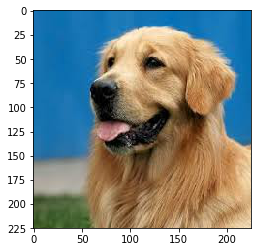

This dog is likely a Golden_retriever


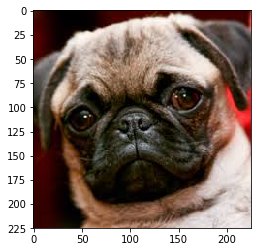

This dog is likely a Bulldog


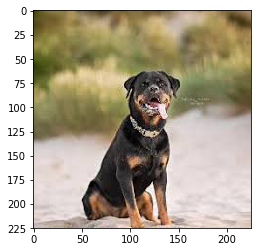

This dog is likely a Beauceron


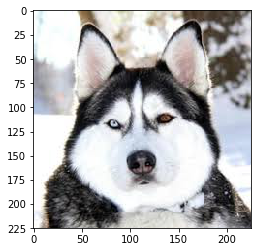

This dog is likely a Alaskan_malamute


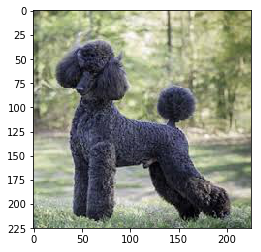

This dog is likely a Poodle


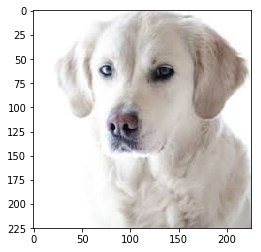

This dog is likely a Anatolian_shepherd_dog


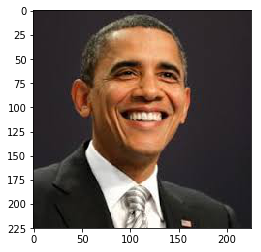

This human resembles a  Silky_terrier


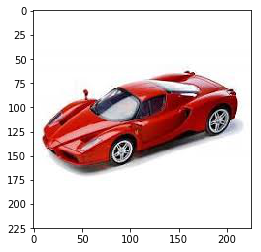

Error - this is neither a human nor a dog


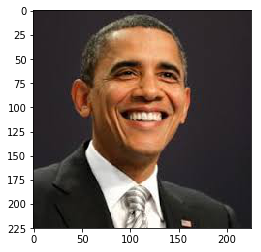

This human resembles a  Silky_terrier


In [27]:
for img in listdir('test_images'):
    dog_breed_classifier('test_images/' + img)